# Classifying OUV using ULMFiT model

## Imports

In [1]:
import sys
sys.executable

'C:\\Users\\zzbn1\\anaconda3\\python.exe'

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.metrics import confusion_matrix

from scipy.special import softmax

import pickle
import matplotlib.pyplot as plt
import random

import torchtext
from torchtext.data import get_tokenizer
#tokenizer = get_tokenizer('spacy')

In [3]:
import fastai
from fastai.text.all import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [4]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [6]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
                
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token='xxunk',
                 mask_token='xxpad', begin_seq_token="xxbos",
                 end_seq_token="xxeos"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = 1
        self.unk_index = 0
        self.begin_seq_index = 2
        self.end_seq_index = 3

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents
    
    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [8]:
class OuvVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, ouv_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
        """
        self.ouv_vocab = ouv_vocab
        
    def vectorize(self, data, vector_length = -1):
        """Create a collapsed one-hit vector for the ouv data
        
        Args:
            data (str): the ouv description data
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vectorized data (np.ndarray)
        """
        indices = []
        indices.extend(self.ouv_vocab.lookup_token(token) for token in data.split(' '))
        #indices.append(self.ouv_vocab.end_seq_index)
        
        if vector_length < 0:
            vector_length = len(indices)
            
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.ouv_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, vocab, cutoff=5):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            ouv_df (pandas.DataFrame): the ouv dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the OuvVectorizer
        """
        
        # Add top words if count > provided count
        #word_counts = Counter()
        #for data in ouv_df.data:
        #    for word in data.split(' '):
        #        if word not in string.punctuation:
        #            word_counts[word] += 1
        
        ouv_vocab = SequenceVocabulary()
        for token in vocab:
            ouv_vocab.add_token(token)
        #for word, count in word_counts.items():
        #    if count > cutoff:
        #        ouv_vocab.add_token(word)

        return cls(ouv_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a OuvVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the OuvVectorizer class
        """
        ouv_vocab = SequenceVocabulary.from_serializable(contents['ouv_vocab'])
        
        return cls(ouv_vocab=ouv_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'ouv_vocab': self.ouv_vocab.to_serializable()}

In [9]:
class OuvDataset(Dataset):
    def __init__(self, ouv_df, vectorizer, vocab):
        """
        Args:
            ouv_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.ouv_df = ouv_df
        self._vectorizer = vectorizer
        self.vocab = vocab
        
        # +0 if not using begin_seq and end seq, +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, ouv_df.data)) + 0

        self.train_df = self.ouv_df[self.ouv_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.ouv_df[self.ouv_df.split=='dev']
        self.validation_size = len(self.val_df)

        self.test_df = self.ouv_df[self.ouv_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, ouv_csv, cutoff, vocab):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            ouv_csv (str): location of the dataset
            cutoff (int): the boundary to set the words into unknown
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        train_ouv_df = ouv_df[ouv_df.split=='train']
        return cls(ouv_df, OuvVectorizer.from_dataframe(cutoff=cutoff, vocab=vocab), vocab=vocab)
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, ouv_csv, vectorizer_filepath, vocab):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            ouv_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(ouv_df, vectorizer, vocab=vocab)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return OuvVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and component for labels (y_target and y_fuzzy)
        """
        row = self._target_df.iloc[index]

        ouv_vector, vec_length = \
            self._vectorizer.vectorize(row.data, self._max_seq_length)

        true_label = \
            np.fromstring(row.true[1:-1],dtype=float, sep=' ')
        
        if len(true_label)==10:
            true_label = np.append(true_label,0.0)
        
        fuzzy_label = \
            np.fromstring(row.fuzzy[1:-1],dtype=float, sep=' ')

        return {'x_data': ouv_vector,
                'y_target': true_label,
                'y_fuzzy': fuzzy_label,
                'x_length': vec_length,
                'id': row.id
               }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [138]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=1,
    model_state_file='model.pth',
    ouv_csv='Data/ouv_with_splits_full.csv',
    big_ouv_csv='Data/all_with_splits_full.csv',
    prior_csv = 'Data/Coappearance_matrix.csv',
    sm_csv = 'Data/Social_media_rome.csv',
    save_dir='model_storage/ulmfit/',
    vectorizer_file='vectorizer.json',
    # Model hyper parameters
    glove_filepath='Data/glove/glove.6B.300d.txt', 
    use_glove=False,
    freeze = True,
    embedding_size=400, 
    hidden_dim=64, 
    bi = False,
    # Training hyper parameters
    batch_size=64,
    early_stopping_criteria=3,
    learning_rate=2e-2,
    l2=1e-5,
    dropout_p=0,
    k = 3,
    fuzzy = True,
    fuzzy_how = 'prior',
    fuzzy_lambda = 0.1,
    num_epochs=10,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

classes = ['Criteria i', 'Criteria ii', 'Criteria iii', 'Criteria iv', 'Criteria v', 'Criteria vi', 
              'Criteria vii', 'Criteria viii', 'Criteria ix', 'Criteria x', 'Others']

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ulmfit/vectorizer.json
	model_storage/ulmfit/model.pth
Using CUDA: True


In [12]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_k_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_1_acc': [],
            'train_k_acc': [],
            'train_k_jac': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_k_acc': [],
            'val_k_jac': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_k_acc':-1,
            'test_k_jac':-1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_k_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_k_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_k_acc_val']:
                train_state['early_stopping_best_k_acc_val'] = acc_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [13]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [14]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

In [15]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [16]:
# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [17]:
def get_prior():
    prior = pd.read_csv(args.prior_csv,sep=';',names=classes[:-1], skiprows=1)
    prior['Others'] = 1
    prior = prior.T
    prior['Others'] = 1
    prior = df_to_tensor(prior)
    return(prior)

In [18]:
def compute_fuzzy_label(y_target, y_fuzzy, fuzzy=False, how='uni', lbd=0):
    '''
    Using two sets of prediction labels and fuzziness parameters to compute the fuzzy label in the form as 
    a distribution over classes
    
    Args:
    y_target (torch.Tensor) of shape (n_batch, n_classes): the true label of the ouv description
    y_fuzzy (torch.Tensor) of shape (n_batch, n_classes): the fuzzy label of the ouv description
    fuzzy (bool): whether or not to turn on the fuzziness option
    how (string): the way fuzziness weights are used, one of the options in {'uni', 'prior'}
    lbd (float): the scaler applied to the fuzziness of the label
    
    Returns:
    A pytorch Tensor of shape (n_batch, n_classes): The processed label in the form of distribution that add to 1
    '''
    assert y_target.shape == y_fuzzy.shape, 'target labels must have the same size'
    assert how in {'uni', 'prior', 'origin'}, '''how must be one of the two options in {'uni', 'prior'}'''
    
    if not fuzzy:
        return softmax_sensitive(y_target)
    
    if how == 'uni':
        y_label = y_target + lbd * y_fuzzy
        return softmax_sensitive(y_label)
    
    ### TO DO ###
    elif how == 'prior':
        prior = get_prior()
        y_inter = torch.matmul(y_target.float(),prior)
        y_inter = y_inter/(y_inter.max(dim=1, keepdim=True)[0])
        y_label = y_target + lbd * y_fuzzy * y_inter
        return softmax_sensitive(y_label)
    
    else:
        y_label = y_target + lbd
        return softmax_sensitive(y_label)

In [19]:
def load_encoder(model, file, device=None):
        "Load the encoder `file` from the model directory, optionally ensuring it's on `device`"
        encoder = model[0]
        if device is None: device = args.device
        if hasattr(encoder, 'module'): encoder = encoder.module
        distrib_barrier()
        wgts = torch.load(args.save_dir + file+'.pth', map_location=device)
        encoder.load_state_dict(clean_raw_keys(wgts))
        for param in encoder.parameters():
            param.requires_grad = False
        #model.freeze()
        return model

In [20]:
ouv_df = pd.read_csv(args.big_ouv_csv)

In [21]:
data_lm = TextDataLoaders.from_df(ouv_df, text_col = 'data', label_col = 'true', path = "", is_lm=True)
vocab = data_lm.vocab

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [22]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = OuvDataset.load_dataset_and_load_vectorizer(args.ouv_csv, args.vectorizer_file, vocab=vocab)

else:
    # create dataset and vectorizer
    dataset = OuvDataset.load_dataset_and_make_vectorizer(args.ouv_csv, cutoff=args.frequency_cutoff, vocab=vocab)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()
set_seed_everywhere(args.seed, args.cuda)

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.ouv_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Not using pre-trained embeddings


## Train a Domain-specific Language Model using whole data

### Loading Data and Prepare Model

In [23]:
ouv_df = pd.read_csv(args.big_ouv_csv)

In [24]:
data_lm = TextDataLoaders.from_df(ouv_df, text_col = 'data', label_col = 'true', path = "", is_lm=True)
vocab = data_lm.vocab

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [25]:
len(vocab)

10536

### Loading Model for Classifier Training

In [26]:
classifier = get_text_classifier(AWD_LSTM, len(vocab), len(classes), seq_len=72, config=None, drop_mult=0.5, lin_ftrs=None,
                        ps=None, pad_idx=1, max_len=72*20, y_range=None)
classifier = load_encoder(classifier, 'finetuned')

In [27]:
def freeze_to(model,n):
    param_lists = [param for param in model[0].parameters()]
    frozen_idx = n if n >= 0 else len(param_lists) + n*4
    if frozen_idx >= len(param_lists):
        warn(f"Freezing {frozen_idx} groups; model has {len(param_lists)}; whole model is frozen.")
    for i in range(len(param_lists)):
        if i < frozen_idx:
            param_lists[i].requires_grad = False
        else:
            param_lists[i].requires_grad = True

## Loading Trained Model

### Option 1 LS Model

In [28]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('prior', 0.1)]

In [29]:
classifier.load_state_dict(torch.load(args.save_dir+'1337/model.pth',map_location=torch.device('cpu')))
classifier.eval()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(10536, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(10536, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

### Option 2 Baseline w/o LS

In [222]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('prior', 0)]

In [241]:
classifier.load_state_dict(torch.load(args.save_dir+'baseline/model.pth',map_location=torch.device('cpu')))
classifier.eval()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(10536, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(10536, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
count_parameters(classifier)

24550730

## Inference

In [31]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [84]:
def predict_rating(text, classifier, vectorizer, classes, k=1):
    """Predict the rating of a review
    
    Args:
        text (str): the text of the description
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    ouv = preprocess_text(str(text))
    
    classifier.eval()
    vectorized_ouv = torch.tensor(vectorizer.vectorize(ouv)[0])
    X = vectorized_ouv.view(1,-1)
    result = classifier(vectorized_ouv.unsqueeze(0))[0]
    result = F.softmax(result, dim=1)
    
    if k==1:
        pred_id = result.argmax().item()
        return (classes[pred_id], result[0][pred_id])
    else:
        pred_indices = [i.item() for i in result.topk(k)[1][0]]
        output = []
        for pred_id in pred_indices:
            output.append((classes[pred_id],result[0][pred_id].item()))
        return output

In [33]:
test_ouv = 'this is a very old building dating back to 13th century'

prediction = predict_rating(test_ouv,classifier,vectorizer,classes)
print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

this is a very old building dating back to 13th century -> Criteria iii with a probability of 0.67


In [34]:
test_ouv = 'this is a very old building dating back to 13th century'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
this is a very old building dating back to 13th century -> Criteria iii with a probability of 0.67
this is a very old building dating back to 13th century -> Criteria iv with a probability of 0.22
this is a very old building dating back to 13th century -> Criteria ii with a probability of 0.05


In [35]:
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
The particular layout of the complex is unique to this site -> Criteria iv with a probability of 0.44
The particular layout of the complex is unique to this site -> Criteria iii with a probability of 0.23
The particular layout of the complex is unique to this site -> Criteria ii with a probability of 0.11


In [36]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.69
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.12
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria ii with a probability of 0.05


In [37]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria i with a probability of 0.33
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria vii with a probability of 0.28
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria iv with a probability of 0.11


In [38]:
test_ouv = '''from torcellos cathedral to the church of santa maria della salute'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
from torcellos cathedral to the church of santa maria della salute -> Criteria vi with a probability of 0.38
from torcellos cathedral to the church of santa maria della salute -> Criteria i with a probability of 0.20
from torcellos cathedral to the church of santa maria della salute -> Criteria ii with a probability of 0.15


In [39]:
test_ouv = '''the years of the republics extraordinary golden age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.25
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.25
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iii with a probability of 0.22


In [40]:
import time
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart))
        
set_seed_everywhere(args.seed, args.cuda)        
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
with Timer():
    predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

Elapsed: 0.019331932067871094


## Predicting scores for Social Media Data

In [42]:
def IoU(a,b):
    i = set(a).intersection(set(b))
    u = set(a).union(set(b))
    return float(len(i))/len(u)

In [43]:
class_dict = {i:classes[i] for i in range(len(classes))}

### Venezia

In [44]:
sm_df = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [154]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/metadata.csv',sep='\t', index_col = 'Unnamed: 0').reset_index().rename(columns={'level_0':'origin'})

In [79]:
def record_ouv(line, classifier=classifier, vectorizer=vectorizer, classes=classes, k=11):
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k)
    for key, value in predictions:
        line[key] = value

In [80]:
new_dict = {}
for i in range(len(sm_df)):
    new_dict[i]={}
    line = sm_df.iloc[i].copy()
    predictions = predict_rating(line['sentence'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        new_dict[i][key] = value
    if len(new_dict)%100==0:
        print('{}/{} finished'.format(len(new_dict),len(sm_df)))

In [86]:
des_dict = {}
for i in range(len(sm_all_df)):
    des_dict[i]={}
    line = sm_all_df.iloc[i].copy()
    predictions = predict_rating(line['revised_text'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        des_dict[i][key] = value
    if len(des_dict)%100==0:
        print('{}/{} finished'.format(len(des_dict),len(sm_all_df)))

100/2951 finished
200/2951 finished
300/2951 finished
400/2951 finished
500/2951 finished
600/2951 finished
700/2951 finished
800/2951 finished
900/2951 finished
1000/2951 finished
1100/2951 finished
1200/2951 finished
1300/2951 finished
1400/2951 finished
1500/2951 finished
1600/2951 finished
1700/2951 finished
1800/2951 finished
1900/2951 finished
2000/2951 finished
2100/2951 finished
2200/2951 finished
2300/2951 finished
2400/2951 finished
2500/2951 finished
2600/2951 finished
2700/2951 finished
2800/2951 finished
2900/2951 finished


In [112]:
score_df = pd.DataFrame(new_dict).reindex(classes).T
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,0.003724,0.000033
1,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,0.007108,0.000062
2,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,0.004332,0.000034
3,0.143317,0.067548,0.348501,0.206013,0.024100,0.161014,0.025110,0.014006,0.004332,0.005646,0.000413
4,0.012331,0.028577,0.141579,0.024646,0.009571,0.774415,0.004108,0.000640,0.000626,0.002715,0.000792
...,...,...,...,...,...,...,...,...,...,...,...
4552,0.104771,0.154656,0.368583,0.145719,0.017407,0.156632,0.021453,0.010011,0.008845,0.011811,0.000113
4553,0.104771,0.154656,0.368583,0.145719,0.017407,0.156632,0.021453,0.010011,0.008845,0.011811,0.000113
4554,0.179463,0.122015,0.171377,0.110938,0.009676,0.333300,0.021827,0.022300,0.009031,0.018681,0.001390
4555,0.126042,0.060049,0.293035,0.140538,0.012537,0.186152,0.063421,0.059563,0.022375,0.035624,0.000663


In [157]:
score_all_df = pd.DataFrame(des_dict).reindex(classes).T
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,0.003724,0.000033
1,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,0.007108,0.000062
2,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,0.004332,0.000034
3,0.053406,0.038182,0.470955,0.194197,0.032737,0.200104,0.004055,0.003042,0.001213,0.001662,0.000449
4,0.236283,0.188700,0.147055,0.247691,0.029092,0.142973,0.002966,0.002041,0.001215,0.001437,0.000547
...,...,...,...,...,...,...,...,...,...,...,...
2946,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025
2947,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025
2948,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025
2949,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025


In [113]:
a = score_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [114]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([score_df, df1, df2], axis=1).reindex(c, axis=1)

In [115]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,0.003724,0.000033,0.358030,Criteria iii,0.300480,Criteria ii,0.172171,Criteria iv,0.358030,0.830680
1,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,0.007108,0.000062,0.399754,Criteria iii,0.203339,Criteria ii,0.156123,Criteria iv,0.399754,0.759217
2,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,0.004332,0.000034,0.345548,Criteria iii,0.304376,Criteria ii,0.164574,Criteria iv,0.345548,0.814499
3,0.143317,0.067548,0.348501,0.206013,0.024100,0.161014,0.025110,0.014006,0.004332,0.005646,0.000413,0.348501,Criteria iii,0.206013,Criteria iv,0.161014,Criteria vi,0.348501,0.715528
4,0.012331,0.028577,0.141579,0.024646,0.009571,0.774415,0.004108,0.000640,0.000626,0.002715,0.000792,0.774415,Criteria vi,0.141579,Criteria iii,0.028577,Criteria ii,0.774415,0.944572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,0.104771,0.154656,0.368583,0.145719,0.017407,0.156632,0.021453,0.010011,0.008845,0.011811,0.000113,0.368583,Criteria iii,0.156632,Criteria vi,0.154656,Criteria ii,0.368583,0.679870
4553,0.104771,0.154656,0.368583,0.145719,0.017407,0.156632,0.021453,0.010011,0.008845,0.011811,0.000113,0.368583,Criteria iii,0.156632,Criteria vi,0.154656,Criteria ii,0.368583,0.679870
4554,0.179463,0.122015,0.171377,0.110938,0.009676,0.333300,0.021827,0.022300,0.009031,0.018681,0.001390,0.333300,Criteria vi,0.179463,Criteria i,0.171377,Criteria iii,0.333300,0.684141
4555,0.126042,0.060049,0.293035,0.140538,0.012537,0.186152,0.063421,0.059563,0.022375,0.035624,0.000663,0.293035,Criteria iii,0.186152,Criteria vi,0.140538,Criteria iv,0.293035,0.619725


In [118]:
sm_df = sm_df.merge(score_df, how='left', left_index=True, right_index=True)

In [158]:
a = score_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [159]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([score_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [160]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,0.003724,0.000033,0.358030,Criteria iii,0.300480,Criteria ii,0.172171,Criteria iv,0.358030,0.830680
1,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,0.007108,0.000062,0.399754,Criteria iii,0.203339,Criteria ii,0.156123,Criteria iv,0.399754,0.759217
2,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,0.004332,0.000034,0.345548,Criteria iii,0.304376,Criteria ii,0.164574,Criteria iv,0.345548,0.814499
3,0.053406,0.038182,0.470955,0.194197,0.032737,0.200104,0.004055,0.003042,0.001213,0.001662,0.000449,0.470955,Criteria iii,0.200104,Criteria vi,0.194197,Criteria iv,0.470955,0.865256
4,0.236283,0.188700,0.147055,0.247691,0.029092,0.142973,0.002966,0.002041,0.001215,0.001437,0.000547,0.247691,Criteria iv,0.236283,Criteria i,0.188700,Criteria ii,0.247691,0.672674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238
2947,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238
2948,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238
2949,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238


In [161]:
sm_all_df = sm_all_df.merge(score_all_df, how='left', left_index=True, right_index=True)
sm_all_df['valid'] = sm_all_df['revised_text'].apply(lambda x: str(x)!='nan')

In [162]:
sm_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,3,51870743082,1,https://live.staticflickr.com/65535/51870743082_d197fdcb50_c.jpg,https://live.staticflickr.com/65535/51870743082_d197fdcb50_q.jpg,https://live.staticflickr.com/65535/51870743082_d197fdcb50_n.jpg,https://live.staticflickr.com/65535/51870743082_26e0f10292_o.jpg,47954272@N06,"Tallinn, Estonia",...,...,0.000033,0.358030,Criteria iii,0.300480,Criteria ii,0.172171,Criteria iv,0.358030,0.830680,True
1,4,51871789478,1,https://live.staticflickr.com/65535/51871789478_829f1d0c28_c.jpg,https://live.staticflickr.com/65535/51871789478_829f1d0c28_q.jpg,https://live.staticflickr.com/65535/51871789478_829f1d0c28_n.jpg,https://live.staticflickr.com/65535/51871789478_54105a6b9b_o.jpg,47954272@N06,"Tallinn, Estonia",...,...,0.000062,0.399754,Criteria iii,0.203339,Criteria ii,0.156123,Criteria iv,0.399754,0.759217,True
2,5,51870742942,1,https://live.staticflickr.com/65535/51870742942_f1a9e654a1_c.jpg,https://live.staticflickr.com/65535/51870742942_f1a9e654a1_q.jpg,https://live.staticflickr.com/65535/51870742942_f1a9e654a1_n.jpg,https://live.staticflickr.com/65535/51870742942_ed1244e911_o.jpg,47954272@N06,"Tallinn, Estonia",...,...,0.000034,0.345548,Criteria iii,0.304376,Criteria ii,0.164574,Criteria iv,0.345548,0.814499,True
3,6,51870380541,1,https://live.staticflickr.com/65535/51870380541_bedca7dfda_c.jpg,https://live.staticflickr.com/65535/51870380541_bedca7dfda_q.jpg,https://live.staticflickr.com/65535/51870380541_bedca7dfda_n.jpg,https://live.staticflickr.com/65535/51870380541_d6e45411c4_o.jpg,64148082@N02,NaN,VENEZIA. CARNEVALE 2019,...,0.000449,0.470955,Criteria iii,0.200104,Criteria vi,0.194197,Criteria iv,0.470955,0.865256,True
4,13,51863124066,1,https://live.staticflickr.com/65535/51863124066_3064973069_c.jpg,https://live.staticflickr.com/65535/51863124066_3064973069_q.jpg,https://live.staticflickr.com/65535/51863124066_3064973069_n.jpg,https://live.staticflickr.com/65535/51863124066_27314f2f56_o.jpg,186704588@N07,NaN,Venice - Ponte dei Sospiri,...,0.000547,0.247691,Criteria iv,0.236283,Criteria i,0.188700,Criteria ii,0.247691,0.672674,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,4981,51233430558,1,https://live.staticflickr.com/65535/51233430558_5be4b3ccc7_c.jpg,https://live.staticflickr.com/65535/51233430558_5be4b3ccc7_q.jpg,https://live.staticflickr.com/65535/51233430558_5be4b3ccc7_n.jpg,https://live.staticflickr.com/65535/51233430558_876677cba3_o.jpg,83293103@N00,"Milano, Italy",20210520_145859,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True
2947,4982,51234286630,1,https://live.staticflickr.com/65535/51234286630_f490cfba4d_c.jpg,https://live.staticflickr.com/65535/51234286630_f490cfba4d_q.jpg,https://live.staticflickr.com/65535/51234286630_f490cfba4d_n.jpg,https://live.staticflickr.com/65535/51234286630_7794c6246f_o.jpg,83293103@N00,"Milano, Italy",20210520_145745,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True
2948,4983,51234294135,1,https://live.staticflickr.com/65535/51234294135_11fbdbbab8_c.jpg,https://live.staticflickr.com/65535/51234294135_11fbdbbab8_q.jpg,https://live.staticflickr.com/65535/51234294135_11fbdbbab8_n.jpg,https://live.staticflickr.com/65535/51234294135_71d647f828_o.jpg,83293103@N00,"Milano, Italy",20210520_164727,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True
2949,4984,51234291635,1,https://live.staticflickr.com/65535/51234291635_4cbc7c4ce5_c.jpg,https://live.staticflickr.com/65535/51234291635_4cbc7c4ce5_q.jpg,https://live.staticflickr.com/65535/51234291635_4cbc7c4ce5_n.jpg,https://live.staticflickr.com/65535/51234291635_a850374644_o.jpg,83293103@N00,"Milano, Italy",20210520_155646,...,0.000025,0.462594,Criteria iii,0.258027,Cr

In [141]:
sm_agg_df = sm_df[classes+['origin']].groupby('origin').mean().reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,3,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,0.003724,0.000033
1,4,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,0.007108,0.000062
2,5,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,0.004332,0.000034
3,6,0.055417,0.042262,0.328887,0.144357,0.017397,0.371280,0.016876,0.011530,0.004458,0.007134,0.000402
4,13,0.175743,0.146366,0.192433,0.174829,0.032636,0.182183,0.040901,0.020022,0.018728,0.015696,0.000463
...,...,...,...,...,...,...,...,...,...,...,...,...
1756,4981,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025
1757,4982,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025
1758,4983,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025
1759,4984,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,0.001373,0.000025


In [142]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [143]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [145]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','sentence']].groupby('origin').count().reset_index()['sentence']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,3,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,...,0.000033,0.358030,Criteria iii,0.300480,Criteria ii,0.172171,Criteria iv,0.358030,0.830680,1
1,4,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,...,0.000062,0.399754,Criteria iii,0.203339,Criteria ii,0.156123,Criteria iv,0.399754,0.759217,1
2,5,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,...,0.000034,0.345548,Criteria iii,0.304376,Criteria ii,0.164574,Criteria iv,0.345548,0.814499,1
3,6,0.055417,0.042262,0.328887,0.144357,0.017397,0.371280,0.016876,0.011530,0.004458,...,0.000402,0.371280,Criteria vi,0.328887,Criteria iii,0.144357,Criteria iv,0.371280,0.844524,9
4,13,0.175743,0.146366,0.192433,0.174829,0.032636,0.182183,0.040901,0.020022,0.018728,...,0.000463,0.192433,Criteria iii,0.182183,Criteria vi,0.175743,Criteria i,0.192433,0.550358,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,4981,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,1
1757,4982,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,1
1758,4983,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,1
1759,4984,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,0.000025,0.462594,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,1


In [146]:
score_df['max_1_col'].value_counts()

Criteria iii     1826
Criteria vi      1217
Criteria i        508
Criteria ii       429
Criteria iv       271
Criteria vii      181
Criteria viii      67
Criteria x         32
Criteria v         19
Criteria ix         7
Name: max_1_col, dtype: int64

In [147]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria iii     3741
Criteria vi      2914
Criteria iv      2732
Criteria ii      1832
Criteria i       1515
Criteria vii      389
Criteria viii     247
Criteria x        164
Criteria ix        76
Criteria v         61
dtype: int64

In [163]:
sm_all_df[sm_all_df.valid]['max_1_col'].value_counts()

Criteria iii     1161
Criteria vi       646
Criteria ii       377
Criteria iv       130
Criteria i        130
Criteria viii     125
Criteria vii       30
Criteria x          8
Criteria ix         2
Criteria v          1
Name: max_1_col, dtype: int64

In [165]:
pd.concat([score_all_df[sm_all_df.valid]['max_1_col'],
           score_all_df[sm_all_df.valid]['max_2_col'],
           score_all_df[sm_all_df.valid]['max_3_col']]).value_counts()

Criteria iii     2291
Criteria vi      2120
Criteria iv      1300
Criteria ii      1064
Criteria i        592
Criteria vii      218
Criteria viii     148
Criteria x         64
Criteria v         25
Criteria ix         8
dtype: int64

In [166]:
score_agg_df['max_1_col'].value_counts()

Criteria iii     1027
Criteria vi       353
Criteria ii       151
Criteria i        114
Criteria iv        51
Criteria vii       42
Criteria viii      14
Criteria x          8
Criteria ix         1
Name: max_1_col, dtype: int64

In [167]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria iii     1672
Criteria vi      1455
Criteria iv       862
Criteria ii       595
Criteria i        432
Criteria vii      185
Criteria viii      45
Criteria x         29
Criteria ix         7
Criteria v          1
dtype: int64

In [174]:
sm_df['max_1']

0       0.358030
1       0.399754
2       0.345548
3       0.348501
4       0.774415
          ...   
4552    0.368583
4553    0.368583
4554    0.333300
4555    0.293035
4556    0.358972
Name: max_1, Length: 4557, dtype: float64

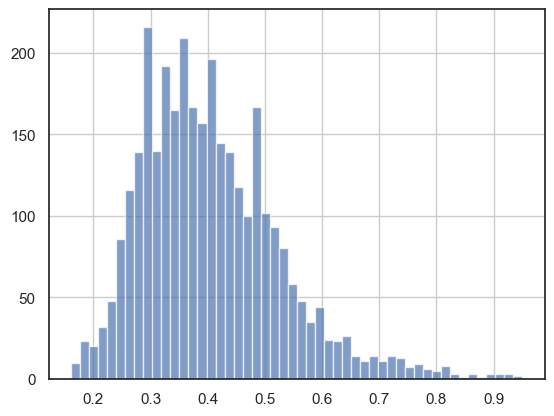

In [180]:
import seaborn as sns
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)
plt.show()

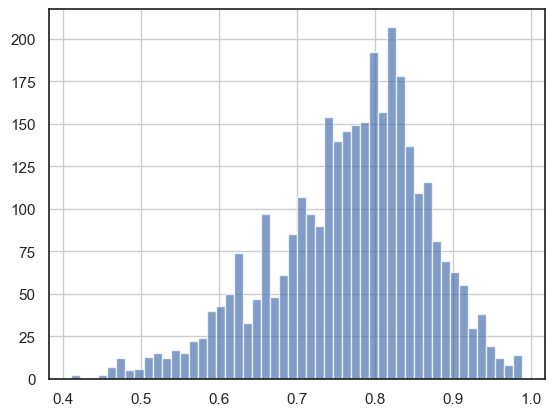

In [181]:
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)
plt.show()

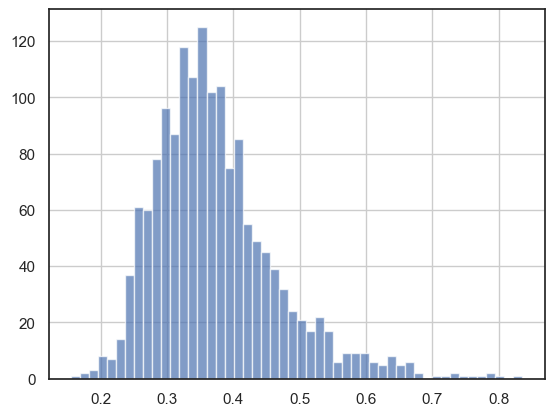

In [183]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_1'].hist(alpha=.7, bins=50)
plt.show()

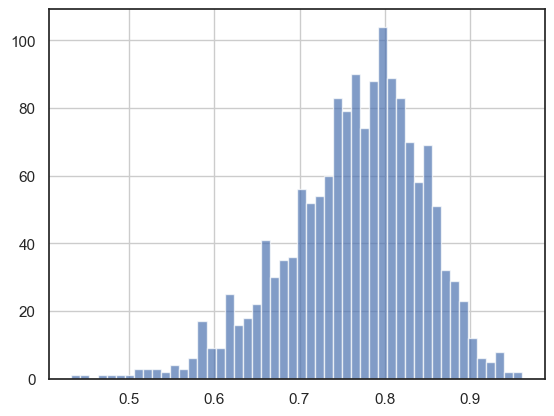

In [184]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_3'].hist(alpha=.7, bins=50)
plt.show()

In [185]:
compare = score_agg_df.merge(sm_all_df, how = 'left', left_on='origin', right_on='origin')

In [186]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [187]:
compare['max_1_eq'].mean()

0.8001135718341851

In [188]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.7254290171606864

In [189]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [190]:
compare['max_3_eq'].mean()

0.8347529812606473

In [191]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.7730109204368175

In [182]:
len(score_df[(score_df.max_3>0.8) & (score_df.max_1>1./3)])

1857

In [192]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [193]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [194]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,3,0.033705,0.300480,0.358030,0.172171,0.025328,0.098227,0.002784,0.002034,0.003484,...,Criteria iii,0.300480,Criteria ii,0.172171,Criteria iv,0.358030,0.830680,True,True,1.0
1,4,0.064877,0.203339,0.399754,0.156123,0.022062,0.128423,0.007169,0.004896,0.006185,...,Criteria iii,0.203339,Criteria ii,0.156123,Criteria iv,0.399754,0.759217,True,True,1.0
2,5,0.039328,0.304376,0.345548,0.164574,0.026383,0.106062,0.003234,0.002186,0.003941,...,Criteria iii,0.304376,Criteria ii,0.164574,Criteria iv,0.345548,0.814499,True,True,1.0
3,6,0.055417,0.042262,0.328887,0.144357,0.017397,0.371280,0.016876,0.011530,0.004458,...,Criteria iii,0.200104,Criteria vi,0.194197,Criteria iv,0.470955,0.865256,True,False,1.0
4,13,0.175743,0.146366,0.192433,0.174829,0.032636,0.182183,0.040901,0.020022,0.018728,...,Criteria iv,0.236283,Criteria i,0.188700,Criteria ii,0.247691,0.672674,True,False,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,4981,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True,True,1.0
1757,4982,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True,True,1.0
1758,4983,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True,True,1.0
1759,4984,0.064827,0.144617,0.462594,0.258027,0.028800,0.034974,0.001452,0.001590,0.001721,...,Criteria iii,0.258027,Criteria iv,0.144617,Criteria ii,0.462594,0.865238,True,True,1.0


In [195]:
score_final = sm_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [196]:
score_final

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,3,51870743082,1,https://live.staticflickr.com/65535/51870743082_d197fdcb50_c.jpg,https://live.staticflickr.com/65535/51870743082_d197fdcb50_q.jpg,https://live.staticflickr.com/65535/51870743082_d197fdcb50_n.jpg,https://live.staticflickr.com/65535/51870743082_26e0f10292_o.jpg,47954272@N06,"Tallinn, Estonia",...,...,0.172171,Criteria iv,0.358030,0.830680,True,Criteria iii,Criteria ii,Criteria iv,True,1.0
1,4,51871789478,1,https://live.staticflickr.com/65535/51871789478_829f1d0c28_c.jpg,https://live.staticflickr.com/65535/51871789478_829f1d0c28_q.jpg,https://live.staticflickr.com/65535/51871789478_829f1d0c28_n.jpg,https://live.staticflickr.com/65535/51871789478_54105a6b9b_o.jpg,47954272@N06,"Tallinn, Estonia",...,...,0.156123,Criteria iv,0.399754,0.759217,True,Criteria iii,Criteria ii,Criteria iv,True,1.0
2,5,51870742942,1,https://live.staticflickr.com/65535/51870742942_f1a9e654a1_c.jpg,https://live.staticflickr.com/65535/51870742942_f1a9e654a1_q.jpg,https://live.staticflickr.com/65535/51870742942_f1a9e654a1_n.jpg,https://live.staticflickr.com/65535/51870742942_ed1244e911_o.jpg,47954272@N06,"Tallinn, Estonia",...,...,0.164574,Criteria iv,0.345548,0.814499,True,Criteria iii,Criteria ii,Criteria iv,True,1.0
3,6,51870380541,1,https://live.staticflickr.com/65535/51870380541_bedca7dfda_c.jpg,https://live.staticflickr.com/65535/51870380541_bedca7dfda_q.jpg,https://live.staticflickr.com/65535/51870380541_bedca7dfda_n.jpg,https://live.staticflickr.com/65535/51870380541_d6e45411c4_o.jpg,64148082@N02,NaN,VENEZIA. CARNEVALE 2019,...,0.194197,Criteria iv,0.470955,0.865256,True,Criteria vi,Criteria iii,Criteria iv,False,1.0
4,13,51863124066,1,https://live.staticflickr.com/65535/51863124066_3064973069_c.jpg,https://live.staticflickr.com/65535/51863124066_3064973069_q.jpg,https://live.staticflickr.com/65535/51863124066_3064973069_n.jpg,https://live.staticflickr.com/65535/51863124066_27314f2f56_o.jpg,186704588@N07,NaN,Venice - Ponte dei Sospiri,...,0.188700,Criteria ii,0.247691,0.672674,True,Criteria iii,Criteria vi,Criteria i,False,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,4981,51233430558,1,https://live.staticflickr.com/65535/51233430558_5be4b3ccc7_c.jpg,https://live.staticflickr.com/65535/51233430558_5be4b3ccc7_q.jpg,https://live.staticflickr.com/65535/51233430558_5be4b3ccc7_n.jpg,https://live.staticflickr.com/65535/51233430558_876677cba3_o.jpg,83293103@N00,"Milano, Italy",20210520_145859,...,0.144617,Criteria ii,0.462594,0.865238,True,Criteria iii,Criteria iv,Criteria ii,True,1.0
2947,4982,51234286630,1,https://live.staticflickr.com/65535/51234286630_f490cfba4d_c.jpg,https://live.staticflickr.com/65535/51234286630_f490cfba4d_q.jpg,https://live.staticflickr.com/65535/51234286630_f490cfba4d_n.jpg,https://live.staticflickr.com/65535/51234286630_7794c6246f_o.jpg,83293103@N00,"Milano, Italy",20210520_145745,...,0.144617,Criteria ii,0.462594,0.865238,True,Criteria iii,Criteria iv,Criteria ii,True,1.0
2948,4983,51234294135,1,https://live.staticflickr.com/65535/51234294135_11fbdbbab8_c.jpg,https://live.staticflickr.com/65535/51234294135_11fbdbbab8_q.jpg,https://live.staticflickr.com/65535/51234294135_11fbdbbab8_n.jpg,https://live.staticflickr.com/65535/51234294135_71d647f828_o.jpg,83293103@N00,"Milano, Italy",20210520_164727,...,0.144617,Criteria ii,0.462594,0.865238,True,Criteria iii,Criteria iv,Criteria ii,True,1.0
2949,4984,51234291635,1,https://live.staticflickr.com/65535/51234291635_4cbc7c4ce5_c.jpg,https://live.staticflickr.com/65535/51234291635_4cbc7c4ce5_q.jpg,https://live.staticflickr.com/65535/51234291635_4cbc7c4ce5_n.jpg,https://live.staticflickr.com/65535/51234291635_a850374644_o.jpg,83293103@N00,"Milano, Italy",20210520_155646,...,0.144617,Criteria ii,0.462594,0.865238,True,Criteria iii,Criteria iv,Crite

In [197]:
sm_df.to_csv('../../../Venice_Flickr/Venezia/data_storage/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/Venezia/data_storage/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig')

In [426]:
sm_df=pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final=pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

In [404]:
sm_df_bert = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final_bert = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

In [427]:
compare_sent = sm_df.iloc[:,:4]
compare_sent['max_1_col_ulmfit'] = sm_df['max_1_col']
compare_sent['max_2_col_ulmfit'] = sm_df['max_2_col']
compare_sent['max_3_col_ulmfit'] = sm_df['max_3_col']
compare_sent['max_1_ulmfit'] = sm_df['max_1']
compare_sent['max_3_ulmfit'] = sm_df['max_3']
compare_sent['max_1_col_bert'] = sm_df_bert['max_1_col']
compare_sent['max_2_col_bert'] = sm_df_bert['max_2_col']
compare_sent['max_3_col_bert'] = sm_df_bert['max_3_col']
compare_sent['max_1_bert'] = sm_df_bert['max_1']
compare_sent['max_3_bert'] = sm_df_bert['max_3']

In [428]:
compare_sent['same_1'] = compare_sent['max_1_col_ulmfit']==compare_sent['max_1_col_bert']

In [429]:
compare_sent['same_3'] = compare_sent.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [430]:
compare_sent['same_1'].mean()

0.2538951064296686

In [409]:
(compare_sent['same_3']>=0.5).mean()

0.6359447004608295

In [235]:
compare_sent[compare_sent['same_3']>=0.5]

,index,sentence,origin,lang,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3
0,0,"It has tags of adriaticsea, italy, venice, bridge, water",3,en,Criteria iii,Criteria ii,Criteria iv,0.358030,0.830680,Criteria ii,Criteria iv,Criteria i,0.362388,0.787226,False,0.5
1,1,"It has tags of adriaticsea, italy, venice",4,en,Criteria iii,Criteria ii,Criteria iv,0.399754,0.759217,Criteria ii,Criteria i,Criteria iv,0.638658,0.898092,False,0.5
2,2,"It has tags of adriaticsea, italy, venice, water",5,en,Criteria iii,Criteria ii,Criteria iv,0.345548,0.814499,Criteria ii,Criteria i,Criteria iv,0.396352,0.812845,False,0.5
3,3,"THE KNIGHT WITH A GRIM LOOK The Carnival of Venice, if not the most grandiose, is certainly the best known for the charm it exerts and the mystery it continues to possess even now that 900 years have passed since the first document that refers to this famous festival",6,en,Criteria iii,Criteria iv,Criteria vi,0.348501,0.715528,Criteria vi,Criteria i,Criteria iii,0.424027,0.843877,False,0.5
4,4,Who has never heard of it,6,en,Criteria vi,Criteria iii,Criteria ii,0.774415,0.944572,Criteria i,Criteria iii,Criteria vi,0.339140,0.709100,False,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,1227,"It has tags of venice, murano",4836,other,Criteria iii,Criteria vi,Criteria ii,0.368583,0.679870,Criteria i,Criteria ii,Criteria iii,0.849580,0.933448,False,0.5
4552,1228,"It has tags of venice, murano",4837,other,Criteria iii,Criteria vi,Criteria ii,0.368583,0.679870,Criteria i,Criteria ii,Criteria iii,0.849580,0.933448,False,0.5
4553,1229,"It has tags of venice, murano",4838,other,Criteria iii,Criteria vi,Criteria ii,0.368583,0.679870,Criteria i,Criteria ii,Criteria iii,0.849580,0.933448,False,0.5
4555,1231,It has title of Frontage,4857,other,Criteria iii,Criteria vi,Criteria iv,0.293035,0.619725,Criteria iv,Criteria i,Criteria iii,0.543409,0.873502,False,0.5


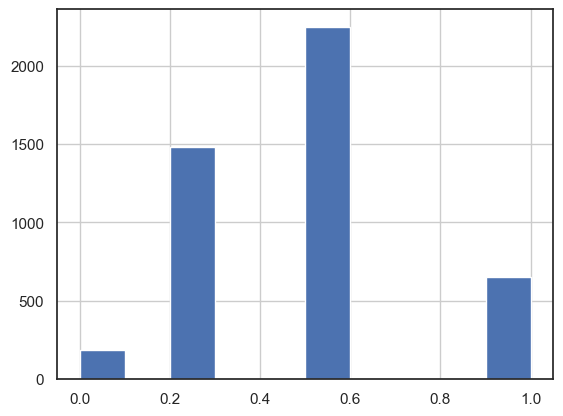

In [410]:
compare_sent['same_3'].hist()
plt.show()

In [431]:
compare_post = score_final.iloc[:,:2]
compare_post['max_1_col_ulmfit'] = score_final['max_1_col']
compare_post['max_2_col_ulmfit'] = score_final['max_2_col']
compare_post['max_3_col_ulmfit'] = score_final['max_3_col']
compare_post['max_1_ulmfit'] = score_final['max_1']
compare_post['max_3_ulmfit'] = score_final['max_3']
compare_post['max_1_col_bert'] = score_final_bert['max_1_col']
compare_post['max_2_col_bert'] = score_final_bert['max_2_col']
compare_post['max_3_col_bert'] = score_final_bert['max_3_col']
compare_post['max_1_bert'] = score_final_bert['max_1']
compare_post['max_3_bert'] = score_final_bert['max_3']

In [432]:
compare_post['same_1'] = compare_post['max_1_col_ulmfit']==compare_post['max_1_col_bert']

In [433]:
compare_post['same_3'] = compare_post.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [434]:
compare_post['same_1'].mean()

0.20535411724839037

In [415]:
compare_post['same_3'].mean()

0.37739749237546594

In [416]:
(compare_post['same_3']>=0.5).mean()

0.4662826160623517

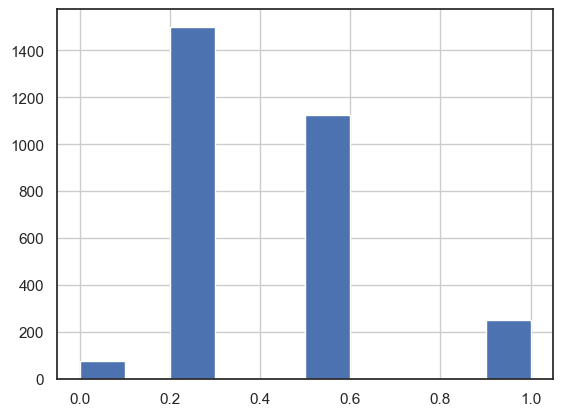

In [417]:
compare_post['same_3'].hist()
plt.show()

In [418]:
from sklearn.metrics.pairwise import cosine_similarity

In [435]:
cs = cosine_similarity(sm_df[classes], sm_df_bert[classes])

In [436]:
compare_sent['cosine_sim'] = np.diagonal(cs)

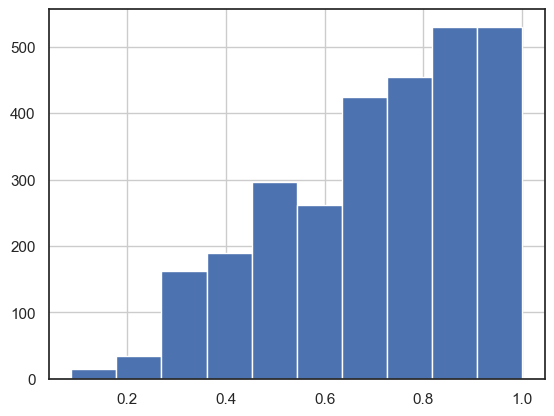

In [443]:
compare_sent[compare_sent.same_3>=0.5]['cosine_sim'].hist()
plt.show()

In [438]:
cs = cosine_similarity(score_final[classes], score_final_bert[classes])

In [439]:
compare_post['cosine_sim'] = np.diagonal(cs)

In [440]:
compare_post

,origin,index,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3,cosine_sim
0,3,51870743082,Criteria iii,Criteria ii,Criteria iv,0.358030,0.830680,Criteria ii,Criteria iv,Criteria i,0.362388,0.787226,False,0.5,0.812573
1,4,51871789478,Criteria iii,Criteria ii,Criteria iv,0.399754,0.759217,Criteria ii,Criteria i,Criteria iv,0.638658,0.898092,False,0.5,0.525624
2,5,51870742942,Criteria iii,Criteria ii,Criteria iv,0.345548,0.814499,Criteria ii,Criteria i,Criteria iv,0.396352,0.812845,False,0.5,0.756251
3,6,51870380541,Criteria iii,Criteria vi,Criteria iv,0.470955,0.865256,Criteria vi,Criteria iii,Criteria iv,0.823930,0.930945,False,1.0,0.462165
4,13,51863124066,Criteria iv,Criteria i,Criteria ii,0.247691,0.672674,Criteria vi,Criteria iv,Criteria i,0.337761,0.871130,False,0.5,0.853685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,4981,51233430558,Criteria iii,Criteria iv,Criteria ii,0.462594,0.865238,Criteria i,Criteria ii,Criteria iv,0.571989,0.903156,False,0.5,0.313572
2947,4982,51234286630,Criteria iii,Criteria iv,Criteria ii,0.462594,0.865238,Criteria i,Criteria ii,Criteria iv,0.571989,0.903156,False,0.5,0.313572
2948,4983,51234294135,Criteria iii,Criteria iv,Criteria ii,0.462594,0.865238,Criteria i,Criteria ii,Criteria iv,0.571989,0.903156,False,0.5,0.313572
2949,4984,51234291635,Criteria iii,Criteria iv,Criteria ii,0.462594,0.865238,Criteria i,Criteria ii,Criteria iv,0.571989,0.903156,False,0.5,0.313572


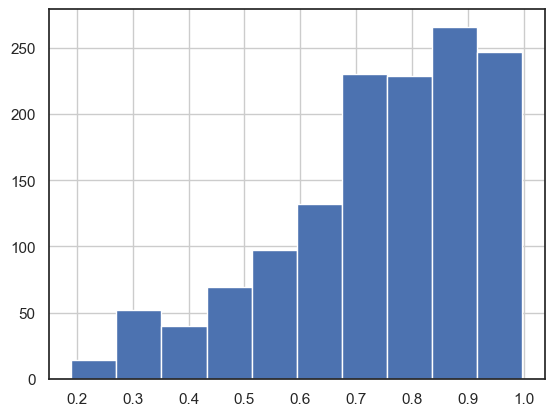

In [442]:
compare_post[compare_post.same_3>=0.5]['cosine_sim'].hist()
plt.show()

In [444]:
compare_sent.to_csv('../../../Venice_Flickr/Venezia/data_storage/sentences_compare.csv',sep='\t', encoding='utf-8-sig')
compare_post.to_csv('../../../Venice_Flickr/Venezia/data_storage/metadata_compare.csv',sep='\t', encoding='utf-8-sig')

### Amsterdam

In [242]:
sm_df = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [243]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata.csv',sep='\t', index_col = 'Unnamed: 0').reset_index().rename(columns={'level_0':'origin'})

In [244]:
def record_ouv(line, classifier=classifier, vectorizer=vectorizer, classes=classes, k=11):
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k)
    for key, value in predictions:
        line[key] = value

In [245]:
new_dict = {}
for i in range(len(sm_df)):
    new_dict[i]={}
    line = sm_df.iloc[i].copy()
    predictions = predict_rating(line['sentence'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        new_dict[i][key] = value
    if len(new_dict)%100==0:
        print('{}/{} finished'.format(len(new_dict),len(sm_df)))

100/9599 finished
200/9599 finished
300/9599 finished
400/9599 finished
500/9599 finished
600/9599 finished
700/9599 finished
800/9599 finished
900/9599 finished
1000/9599 finished
1100/9599 finished
1200/9599 finished
1300/9599 finished
1400/9599 finished
1500/9599 finished
1600/9599 finished
1700/9599 finished
1800/9599 finished
1900/9599 finished
2000/9599 finished
2100/9599 finished
2200/9599 finished
2300/9599 finished
2400/9599 finished
2500/9599 finished
2600/9599 finished
2700/9599 finished
2800/9599 finished
2900/9599 finished
3000/9599 finished
3100/9599 finished
3200/9599 finished
3300/9599 finished
3400/9599 finished
3500/9599 finished
3600/9599 finished
3700/9599 finished
3800/9599 finished
3900/9599 finished
4000/9599 finished
4100/9599 finished
4200/9599 finished
4300/9599 finished
4400/9599 finished
4500/9599 finished
4600/9599 finished
4700/9599 finished
4800/9599 finished
4900/9599 finished
5000/9599 finished
5100/9599 finished
5200/9599 finished
5300/9599 finished
54

In [246]:
des_dict = {}
for i in range(len(sm_all_df)):
    des_dict[i]={}
    line = sm_all_df.iloc[i].copy()
    predictions = predict_rating(line['revised_text'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        des_dict[i][key] = value
    if len(des_dict)%100==0:
        print('{}/{} finished'.format(len(des_dict),len(sm_all_df)))

100/3727 finished
200/3727 finished
300/3727 finished
400/3727 finished
500/3727 finished
600/3727 finished
700/3727 finished
800/3727 finished
900/3727 finished
1000/3727 finished
1100/3727 finished
1200/3727 finished
1300/3727 finished
1400/3727 finished
1500/3727 finished
1600/3727 finished
1700/3727 finished
1800/3727 finished
1900/3727 finished
2000/3727 finished
2100/3727 finished
2200/3727 finished
2300/3727 finished
2400/3727 finished
2500/3727 finished
2600/3727 finished
2700/3727 finished
2800/3727 finished
2900/3727 finished
3000/3727 finished
3100/3727 finished
3200/3727 finished
3300/3727 finished
3400/3727 finished
3500/3727 finished
3600/3727 finished
3700/3727 finished


In [247]:
score_df = pd.DataFrame(new_dict).reindex(classes).T
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.063411,0.183700,0.157456,0.173913,0.008129,0.410730,0.000902,0.000622,0.000472,0.000628,0.000038
1,0.037595,0.129560,0.472180,0.165439,0.041721,0.119189,0.010162,0.005533,0.008944,0.009578,0.000099
2,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,0.009011,0.000039
3,0.216921,0.188141,0.174296,0.202317,0.048151,0.106487,0.027835,0.009027,0.012432,0.014174,0.000218
4,0.096496,0.037656,0.122139,0.068756,0.009859,0.273391,0.156935,0.131684,0.031384,0.067284,0.004416
...,...,...,...,...,...,...,...,...,...,...,...
9594,0.044658,0.149264,0.438163,0.172239,0.036680,0.107794,0.014610,0.007455,0.014052,0.015055,0.000029
9595,0.044658,0.149264,0.438163,0.172239,0.036680,0.107794,0.014610,0.007455,0.014052,0.015055,0.000029
9596,0.132050,0.063876,0.213784,0.200032,0.013147,0.359905,0.006564,0.005049,0.002604,0.002852,0.000138
9597,0.126042,0.060049,0.293035,0.140538,0.012537,0.186152,0.063421,0.059563,0.022375,0.035624,0.000663


In [248]:
score_all_df = pd.DataFrame(des_dict).reindex(classes).T
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.029157,0.262568,0.270707,0.280558,0.026330,0.123254,0.001770,0.001524,0.001927,0.002163,0.000043
1,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,0.009011,0.000039
2,0.137951,0.165506,0.160387,0.228607,0.063707,0.166086,0.025874,0.012238,0.017979,0.021275,0.000388
3,0.013212,0.401489,0.186517,0.199517,0.011723,0.184819,0.000431,0.000706,0.000687,0.000867,0.000032
4,0.070444,0.107359,0.304299,0.235703,0.039951,0.190014,0.013431,0.011113,0.011688,0.015853,0.000145
...,...,...,...,...,...,...,...,...,...,...,...
3722,0.063712,0.112252,0.365005,0.216274,0.033205,0.171184,0.009273,0.008810,0.008268,0.011891,0.000127
3723,0.126379,0.165190,0.292644,0.203834,0.017086,0.167321,0.009093,0.007588,0.004861,0.005882,0.000124
3724,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030
3725,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030


In [249]:
a = score_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [250]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([score_df, df1, df2], axis=1).reindex(c, axis=1)

In [251]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.063411,0.183700,0.157456,0.173913,0.008129,0.410730,0.000902,0.000622,0.000472,0.000628,0.000038,0.410730,Criteria vi,0.183700,Criteria ii,0.173913,Criteria iv,0.410730,0.768343
1,0.037595,0.129560,0.472180,0.165439,0.041721,0.119189,0.010162,0.005533,0.008944,0.009578,0.000099,0.472180,Criteria iii,0.165439,Criteria iv,0.129560,Criteria ii,0.472180,0.767179
2,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,0.009011,0.000039,0.441306,Criteria iii,0.216375,Criteria iv,0.121436,Criteria ii,0.441306,0.779117
3,0.216921,0.188141,0.174296,0.202317,0.048151,0.106487,0.027835,0.009027,0.012432,0.014174,0.000218,0.216921,Criteria i,0.202317,Criteria iv,0.188141,Criteria ii,0.216921,0.607379
4,0.096496,0.037656,0.122139,0.068756,0.009859,0.273391,0.156935,0.131684,0.031384,0.067284,0.004416,0.273391,Criteria vi,0.156935,Criteria vii,0.131684,Criteria viii,0.273391,0.562010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9594,0.044658,0.149264,0.438163,0.172239,0.036680,0.107794,0.014610,0.007455,0.014052,0.015055,0.000029,0.438163,Criteria iii,0.172239,Criteria iv,0.149264,Criteria ii,0.438163,0.759667
9595,0.044658,0.149264,0.438163,0.172239,0.036680,0.107794,0.014610,0.007455,0.014052,0.015055,0.000029,0.438163,Criteria iii,0.172239,Criteria iv,0.149264,Criteria ii,0.438163,0.759667
9596,0.132050,0.063876,0.213784,0.200032,0.013147,0.359905,0.006564,0.005049,0.002604,0.002852,0.000138,0.359905,Criteria vi,0.213784,Criteria iii,0.200032,Criteria iv,0.359905,0.773720
9597,0.126042,0.060049,0.293035,0.140538,0.012537,0.186152,0.063421,0.059563,0.022375,0.035624,0.000663,0.293035,Criteria iii,0.186152,Criteria vi,0.140538,Criteria iv,0.293035,0.619725


In [252]:
sm_df = sm_df.merge(score_df, how='left', left_index=True, right_index=True)

In [253]:
a = score_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [254]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([score_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [255]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.029157,0.262568,0.270707,0.280558,0.026330,0.123254,0.001770,0.001524,0.001927,0.002163,0.000043,0.280558,Criteria iv,0.270707,Criteria iii,0.262568,Criteria ii,0.280558,0.813833
1,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,0.009011,0.000039,0.441306,Criteria iii,0.216375,Criteria iv,0.121436,Criteria ii,0.441306,0.779117
2,0.137951,0.165506,0.160387,0.228607,0.063707,0.166086,0.025874,0.012238,0.017979,0.021275,0.000388,0.228607,Criteria iv,0.166086,Criteria vi,0.165506,Criteria ii,0.228607,0.560199
3,0.013212,0.401489,0.186517,0.199517,0.011723,0.184819,0.000431,0.000706,0.000687,0.000867,0.000032,0.401489,Criteria ii,0.199517,Criteria iv,0.186517,Criteria iii,0.401489,0.787524
4,0.070444,0.107359,0.304299,0.235703,0.039951,0.190014,0.013431,0.011113,0.011688,0.015853,0.000145,0.304299,Criteria iii,0.235703,Criteria iv,0.190014,Criteria vi,0.304299,0.730016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,0.063712,0.112252,0.365005,0.216274,0.033205,0.171184,0.009273,0.008810,0.008268,0.011891,0.000127,0.365005,Criteria iii,0.216274,Criteria iv,0.171184,Criteria vi,0.365005,0.752462
3723,0.126379,0.165190,0.292644,0.203834,0.017086,0.167321,0.009093,0.007588,0.004861,0.005882,0.000124,0.292644,Criteria iii,0.203834,Criteria iv,0.167321,Criteria vi,0.292644,0.663798
3724,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161
3725,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161


In [256]:
sm_all_df = sm_all_df.merge(score_all_df, how='left', left_index=True, right_index=True)
sm_all_df['valid'] = sm_all_df['revised_text'].apply(lambda x: str(x)!='nan')

In [257]:
sm_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,2,51885929339,1.0,https://live.staticflickr.com/65535/51885929339_047ce05277_c.jpg,https://live.staticflickr.com/65535/51885929339_047ce05277_q.jpg,https://live.staticflickr.com/65535/51885929339_047ce05277_n.jpg,https://live.staticflickr.com/65535/51885929339_03ce2e9591_o.jpg,8733637@N04,"Haarlem, The Netherlands",Citroën 2CV 1982,...,0.000043,0.280558,Criteria iv,0.270707,Criteria iii,0.262568,Criteria ii,0.280558,0.813833,True
1,3,51884357517,1.0,https://live.staticflickr.com/65535/51884357517_73d2c871a6_c.jpg,https://live.staticflickr.com/65535/51884357517_73d2c871a6_q.jpg,https://live.staticflickr.com/65535/51884357517_73d2c871a6_n.jpg,https://live.staticflickr.com/65535/51884357517_8eb754431e_o.jpg,150614452@N05,NaN,RFO 9901,...,0.000039,0.441306,Criteria iii,0.216375,Criteria iv,0.121436,Criteria ii,0.441306,0.779117,True
2,8,51883860957,1.0,https://live.staticflickr.com/65535/51883860957_1046863951_c.jpg,https://live.staticflickr.com/65535/51883860957_1046863951_q.jpg,https://live.staticflickr.com/65535/51883860957_1046863951_n.jpg,https://live.staticflickr.com/65535/51883860957_391d98249c_o.jpg,195032295@N04,NaN,"Houseboats, Amsterdam-West",...,0.000388,0.228607,Criteria iv,0.166086,Criteria vi,0.165506,Criteria ii,0.228607,0.560199,True
3,9,51884423594,1.0,https://live.staticflickr.com/65535/51884423594_38ed8d7a64_c.jpg,https://live.staticflickr.com/65535/51884423594_38ed8d7a64_q.jpg,https://live.staticflickr.com/65535/51884423594_38ed8d7a64_n.jpg,https://live.staticflickr.com/65535/51884423594_39ace37a79_o.jpg,8733637@N04,"Haarlem, The Netherlands",Ford Transit minibus 1978,...,0.000032,0.401489,Criteria ii,0.199517,Criteria iv,0.186517,Criteria iii,0.401489,0.787524,True
4,13,51882154188,1.0,https://live.staticflickr.com/65535/51882154188_0948af559d_c.jpg,https://live.staticflickr.com/65535/51882154188_0948af559d_q.jpg,https://live.staticflickr.com/65535/51882154188_0948af559d_n.jpg,https://live.staticflickr.com/65535/51882154188_2b1f87ddcf_o.jpg,8733637@N04,"Haarlem, The Netherlands",Renault Dauphine 1960,...,0.000145,0.304299,Criteria iii,0.235703,Criteria iv,0.190014,Criteria vi,0.304299,0.730016,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,4993,51361633644,1.0,https://live.staticflickr.com/65535/51361633644_ede3b60e37_c.jpg,https://live.staticflickr.com/65535/51361633644_ede3b60e37_q.jpg,https://live.staticflickr.com/65535/51361633644_ede3b60e37_n.jpg,https://live.staticflickr.com/65535/51361633644_95593e8206_o.jpg,78239672@N00,"Kingston upon Hull, UK",Rijksmuseum,...,0.000127,0.365005,Criteria iii,0.216274,Criteria iv,0.171184,Criteria vi,0.365005,0.752462,True
3723,4995,51357996868,1.0,https://live.staticflickr.com/65535/51357996868_82e53268b6_c.jpg,https://live.staticflickr.com/65535/51357996868_82e53268b6_q.jpg,https://live.staticflickr.com/65535/51357996868_82e53268b6_n.jpg,https://live.staticflickr.com/65535/51357996868_389074f277_o.jpg,193393816@N06,NaN,AMSTERDAM,...,0.000124,0.292644,Criteria iii,0.203834,Criteria iv,0.167321,Criteria vi,0.292644,0.663798,True
3724,4996,51356750697,1.0,https://live.staticflickr.com/65535/51356750697_ffe1173a00_c.jpg,https://live.staticflickr.com/65535/51356750697_ffe1173a00_q.jpg,https://live.staticflickr.com/65535/51356750697_ffe1173a00_n.jpg,https://live.staticflickr.com/65535/51356750697_fa4927c603_o.jpg,34476863@N00,the netherlands,NaN,...,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161,False
3725,4997,51358508460,1.0,https://live.staticflickr.com/65535/51358508460_24f6a5d0f9_c.jpg,https://live.staticflickr.com/65535/51358508460_24f6a5d0f9_q.jpg,https://live.staticflickr.com/65535/51358508460_24f6a5d0f9_n.jpg,https://live.staticflickr.com/65535/51358508460_5ce97afb4d_o.jpg,34476863@N00,the netherlands,NaN,

In [258]:
sm_agg_df = sm_df[classes+['origin']].groupby('origin').mean().reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,2,0.050503,0.156630,0.314818,0.169676,0.024925,0.264959,0.005532,0.003077,0.004708,0.005103,0.000069
1,3,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,0.009011,0.000039
2,8,0.152715,0.136390,0.213535,0.171007,0.031778,0.239042,0.021632,0.010642,0.009947,0.012968,0.000345
3,9,0.058416,0.167559,0.196765,0.150599,0.014248,0.278678,0.053060,0.044576,0.011224,0.023375,0.001499
4,13,0.068965,0.117116,0.301381,0.159050,0.020654,0.267579,0.020281,0.016670,0.010699,0.017041,0.000565
...,...,...,...,...,...,...,...,...,...,...,...,...
2899,4990,0.069137,0.062660,0.252103,0.083146,0.012393,0.401202,0.072347,0.008737,0.009502,0.028410,0.000363
2900,4991,0.067804,0.065300,0.310644,0.234954,0.109906,0.130461,0.025942,0.023376,0.012598,0.018467,0.000548
2901,4993,0.072519,0.100623,0.376549,0.162176,0.028314,0.179604,0.023362,0.019599,0.017496,0.019567,0.000191
2902,4995,0.126379,0.165190,0.292644,0.203834,0.017086,0.167321,0.009093,0.007588,0.004861,0.005882,0.000124


In [259]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [260]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [261]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','sentence']].groupby('origin').count().reset_index()['sentence']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,2,0.050503,0.156630,0.314818,0.169676,0.024925,0.264959,0.005532,0.003077,0.004708,...,0.000069,0.314818,Criteria iii,0.264959,Criteria vi,0.169676,Criteria iv,0.314818,0.749454,2
1,3,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,...,0.000039,0.441306,Criteria iii,0.216375,Criteria iv,0.121436,Criteria ii,0.441306,0.779117,1
2,8,0.152715,0.136390,0.213535,0.171007,0.031778,0.239042,0.021632,0.010642,0.009947,...,0.000345,0.239042,Criteria vi,0.213535,Criteria iii,0.171007,Criteria iv,0.239042,0.623584,2
3,9,0.058416,0.167559,0.196765,0.150599,0.014248,0.278678,0.053060,0.044576,0.011224,...,0.001499,0.278678,Criteria vi,0.196765,Criteria iii,0.167559,Criteria ii,0.278678,0.643003,3
4,13,0.068965,0.117116,0.301381,0.159050,0.020654,0.267579,0.020281,0.016670,0.010699,...,0.000565,0.301381,Criteria iii,0.267579,Criteria vi,0.159050,Criteria iv,0.301381,0.728010,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,4990,0.069137,0.062660,0.252103,0.083146,0.012393,0.401202,0.072347,0.008737,0.009502,...,0.000363,0.401202,Criteria vi,0.252103,Criteria iii,0.083146,Criteria iv,0.401202,0.736451,1
2900,4991,0.067804,0.065300,0.310644,0.234954,0.109906,0.130461,0.025942,0.023376,0.012598,...,0.000548,0.310644,Criteria iii,0.234954,Criteria iv,0.130461,Criteria vi,0.310644,0.676059,2
2901,4993,0.072519,0.100623,0.376549,0.162176,0.028314,0.179604,0.023362,0.019599,0.017496,...,0.000191,0.376549,Criteria iii,0.179604,Criteria vi,0.162176,Criteria iv,0.376549,0.718329,5
2902,4995,0.126379,0.165190,0.292644,0.203834,0.017086,0.167321,0.009093,0.007588,0.004861,...,0.000124,0.292644,Criteria iii,0.203834,Criteria iv,0.167321,Criteria vi,0.292644,0.663798,1


In [262]:
score_df['max_1_col'].value_counts()

Criteria iii     3754
Criteria vi      1819
Criteria i       1308
Criteria iv      1033
Criteria ii       782
Criteria vii      391
Criteria ix       259
Criteria x        174
Criteria viii      53
Criteria v         26
Name: max_1_col, dtype: int64

In [263]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria iv      7436
Criteria iii     7202
Criteria vi      4608
Criteria ii      4243
Criteria i       2849
Criteria x        733
Criteria vii      645
Criteria viii     564
Criteria ix       316
Criteria v        201
dtype: int64

In [264]:
sm_all_df[sm_all_df.valid]['max_1_col'].value_counts()

Criteria iii     932
Criteria vi      905
Criteria ii      560
Criteria iv      475
Criteria i       158
Criteria vii      61
Criteria ix       58
Criteria v         8
Criteria x         8
Criteria viii      7
Name: max_1_col, dtype: int64

In [265]:
pd.concat([score_all_df[sm_all_df.valid]['max_1_col'],
           score_all_df[sm_all_df.valid]['max_2_col'],
           score_all_df[sm_all_df.valid]['max_3_col']]).value_counts()

Criteria iv      2619
Criteria iii     2492
Criteria vi      2010
Criteria ii      1562
Criteria i        440
Criteria vii      114
Criteria v         86
Criteria x         85
Criteria ix        76
Criteria viii      32
dtype: int64

In [266]:
score_agg_df['max_1_col'].value_counts()

Criteria iii     1315
Criteria vi      1013
Criteria iv       238
Criteria i        143
Criteria vii       64
Criteria ix        57
Criteria ii        56
Criteria viii      10
Criteria x          8
Name: max_1_col, dtype: int64

In [267]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria iii     2629
Criteria iv      2166
Criteria vi      1956
Criteria ii       951
Criteria i        404
Criteria ix       263
Criteria vii      144
Criteria x         91
Criteria viii      54
Criteria v         54
dtype: int64

In [268]:
sm_df['max_1']

0       0.410730
1       0.472180
2       0.441306
3       0.216921
4       0.273391
          ...   
9594    0.438163
9595    0.438163
9596    0.359905
9597    0.293035
9598    0.292644
Name: max_1, Length: 9599, dtype: float64

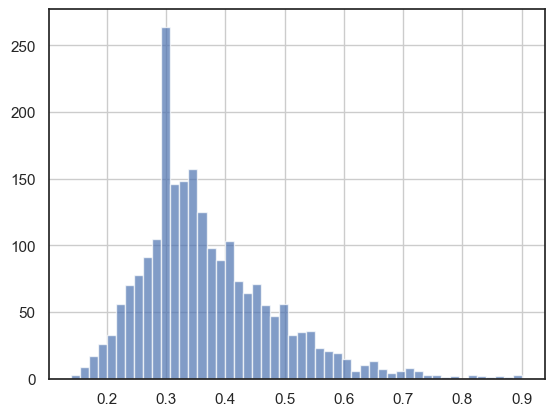

In [269]:
import seaborn as sns
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)
plt.show()

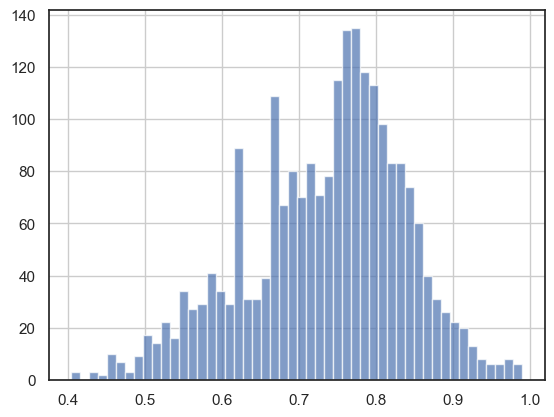

In [270]:
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)
plt.show()

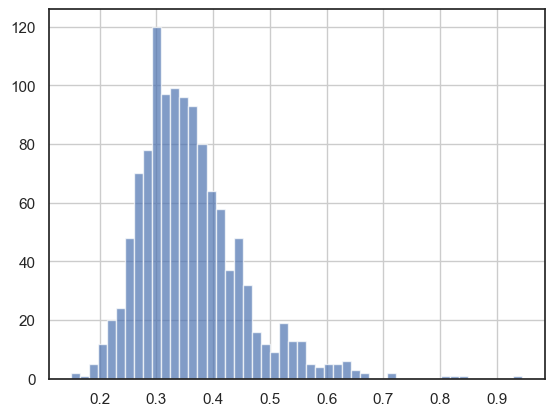

In [271]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_1'].hist(alpha=.7, bins=50)
plt.show()

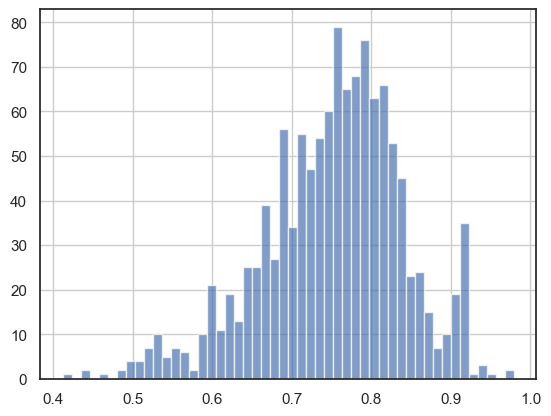

In [272]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_3'].hist(alpha=.7, bins=50)
plt.show()

In [273]:
compare = score_agg_df.merge(sm_all_df, how = 'left', left_on='origin', right_on='origin')

In [274]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [275]:
compare['max_1_eq'].mean()

0.6212121212121212

In [276]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.3728620296465222

In [277]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [278]:
compare['max_3_eq'].mean()

0.8326790633608815

In [279]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.722976054732041

In [280]:
len(score_df[(score_df.max_3>0.8) & (score_df.max_1>1./3)])

2771

In [281]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [282]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [283]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,2,0.050503,0.156630,0.314818,0.169676,0.024925,0.264959,0.005532,0.003077,0.004708,...,Criteria iv,0.270707,Criteria iii,0.262568,Criteria ii,0.280558,0.813833,True,False,0.5
1,3,0.049204,0.121436,0.441306,0.216375,0.036770,0.101294,0.008772,0.006080,0.009712,...,Criteria iii,0.216375,Criteria iv,0.121436,Criteria ii,0.441306,0.779117,True,True,1.0
2,8,0.152715,0.136390,0.213535,0.171007,0.031778,0.239042,0.021632,0.010642,0.009947,...,Criteria iv,0.166086,Criteria vi,0.165506,Criteria ii,0.228607,0.560199,True,False,0.5
3,9,0.058416,0.167559,0.196765,0.150599,0.014248,0.278678,0.053060,0.044576,0.011224,...,Criteria ii,0.199517,Criteria iv,0.186517,Criteria iii,0.401489,0.787524,True,False,0.5
4,13,0.068965,0.117116,0.301381,0.159050,0.020654,0.267579,0.020281,0.016670,0.010699,...,Criteria iii,0.235703,Criteria iv,0.190014,Criteria vi,0.304299,0.730016,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,4990,0.069137,0.062660,0.252103,0.083146,0.012393,0.401202,0.072347,0.008737,0.009502,...,Criteria vi,0.252103,Criteria iii,0.083146,Criteria iv,0.401202,0.736451,True,True,1.0
2900,4991,0.067804,0.065300,0.310644,0.234954,0.109906,0.130461,0.025942,0.023376,0.012598,...,Criteria iii,0.269683,Criteria iv,0.131053,Criteria v,0.415419,0.816155,True,True,0.5
2901,4993,0.072519,0.100623,0.376549,0.162176,0.028314,0.179604,0.023362,0.019599,0.017496,...,Criteria iii,0.216274,Criteria iv,0.171184,Criteria vi,0.365005,0.752462,True,True,1.0
2902,4995,0.126379,0.165190,0.292644,0.203834,0.017086,0.167321,0.009093,0.007588,0.004861,...,Criteria iii,0.203834,Criteria iv,0.167321,Criteria vi,0.292644,0.663798,True,True,1.0


In [284]:
score_final = sm_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [285]:
score_final

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,2,51885929339,1.0,https://live.staticflickr.com/65535/51885929339_047ce05277_c.jpg,https://live.staticflickr.com/65535/51885929339_047ce05277_q.jpg,https://live.staticflickr.com/65535/51885929339_047ce05277_n.jpg,https://live.staticflickr.com/65535/51885929339_03ce2e9591_o.jpg,8733637@N04,"Haarlem, The Netherlands",Citroën 2CV 1982,...,0.262568,Criteria ii,0.280558,0.813833,True,Criteria iii,Criteria vi,Criteria iv,False,0.5
1,3,51884357517,1.0,https://live.staticflickr.com/65535/51884357517_73d2c871a6_c.jpg,https://live.staticflickr.com/65535/51884357517_73d2c871a6_q.jpg,https://live.staticflickr.com/65535/51884357517_73d2c871a6_n.jpg,https://live.staticflickr.com/65535/51884357517_8eb754431e_o.jpg,150614452@N05,NaN,RFO 9901,...,0.121436,Criteria ii,0.441306,0.779117,True,Criteria iii,Criteria iv,Criteria ii,True,1.0
2,8,51883860957,1.0,https://live.staticflickr.com/65535/51883860957_1046863951_c.jpg,https://live.staticflickr.com/65535/51883860957_1046863951_q.jpg,https://live.staticflickr.com/65535/51883860957_1046863951_n.jpg,https://live.staticflickr.com/65535/51883860957_391d98249c_o.jpg,195032295@N04,NaN,"Houseboats, Amsterdam-West",...,0.165506,Criteria ii,0.228607,0.560199,True,Criteria vi,Criteria iii,Criteria iv,False,0.5
3,9,51884423594,1.0,https://live.staticflickr.com/65535/51884423594_38ed8d7a64_c.jpg,https://live.staticflickr.com/65535/51884423594_38ed8d7a64_q.jpg,https://live.staticflickr.com/65535/51884423594_38ed8d7a64_n.jpg,https://live.staticflickr.com/65535/51884423594_39ace37a79_o.jpg,8733637@N04,"Haarlem, The Netherlands",Ford Transit minibus 1978,...,0.186517,Criteria iii,0.401489,0.787524,True,Criteria vi,Criteria iii,Criteria ii,False,0.5
4,13,51882154188,1.0,https://live.staticflickr.com/65535/51882154188_0948af559d_c.jpg,https://live.staticflickr.com/65535/51882154188_0948af559d_q.jpg,https://live.staticflickr.com/65535/51882154188_0948af559d_n.jpg,https://live.staticflickr.com/65535/51882154188_2b1f87ddcf_o.jpg,8733637@N04,"Haarlem, The Netherlands",Renault Dauphine 1960,...,0.190014,Criteria vi,0.304299,0.730016,True,Criteria iii,Criteria vi,Criteria iv,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,4993,51361633644,1.0,https://live.staticflickr.com/65535/51361633644_ede3b60e37_c.jpg,https://live.staticflickr.com/65535/51361633644_ede3b60e37_q.jpg,https://live.staticflickr.com/65535/51361633644_ede3b60e37_n.jpg,https://live.staticflickr.com/65535/51361633644_95593e8206_o.jpg,78239672@N00,"Kingston upon Hull, UK",Rijksmuseum,...,0.171184,Criteria vi,0.365005,0.752462,True,Criteria iii,Criteria vi,Criteria iv,True,1.0
3723,4995,51357996868,1.0,https://live.staticflickr.com/65535/51357996868_82e53268b6_c.jpg,https://live.staticflickr.com/65535/51357996868_82e53268b6_q.jpg,https://live.staticflickr.com/65535/51357996868_82e53268b6_n.jpg,https://live.staticflickr.com/65535/51357996868_389074f277_o.jpg,193393816@N06,NaN,AMSTERDAM,...,0.167321,Criteria vi,0.292644,0.663798,True,Criteria iii,Criteria iv,Criteria vi,True,1.0
3724,4996,51356750697,1.0,https://live.staticflickr.com/65535/51356750697_ffe1173a00_c.jpg,https://live.staticflickr.com/65535/51356750697_ffe1173a00_q.jpg,https://live.staticflickr.com/65535/51356750697_ffe1173a00_n.jpg,https://live.staticflickr.com/65535/51356750697_fa4927c603_o.jpg,34476863@N00,the netherlands,NaN,...,0.026072,Criteria iv,0.835118,0.946161,False,NaN,NaN,NaN,NaN,NaN
3725,4997,51358508460,1.0,https://live.staticflickr.com/65535/51358508460_24f6a5d0f9_c.jpg,https://live.staticflickr.com/65535/51358508460_24f6a5d0f9_q.jpg,https://live.staticflickr.com/65535/51358508460_24f6a5d0f9_n.jpg,https://live.staticflickr.com/65535/51358508460_5ce97afb4d_o.jpg,34476863@N00,the netherlands,NaN,...,0.026072,Criteria iv,0.835118,0.946161,False,NaN,NaN

In [286]:
sm_df.to_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig')

In [446]:
sm_df=pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final=pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

In [448]:
sm_df_bert = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final_bert = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

In [449]:
compare_sent = sm_df.iloc[:,:4]
compare_sent['max_1_col_ulmfit'] = sm_df['max_1_col']
compare_sent['max_2_col_ulmfit'] = sm_df['max_2_col']
compare_sent['max_3_col_ulmfit'] = sm_df['max_3_col']
compare_sent['max_1_ulmfit'] = sm_df['max_1']
compare_sent['max_3_ulmfit'] = sm_df['max_3']
compare_sent['max_1_col_bert'] = sm_df_bert['max_1_col']
compare_sent['max_2_col_bert'] = sm_df_bert['max_2_col']
compare_sent['max_3_col_bert'] = sm_df_bert['max_3_col']
compare_sent['max_1_bert'] = sm_df_bert['max_1']
compare_sent['max_3_bert'] = sm_df_bert['max_3']

In [450]:
compare_sent['same_1'] = compare_sent['max_1_col_ulmfit']==compare_sent['max_1_col_bert']

In [451]:
compare_sent['same_3'] = compare_sent.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [452]:
compare_sent['same_1'].mean()

0.23773309719762475

In [453]:
(compare_sent['same_3']>=0.5).mean()

0.6051672049171789

In [293]:
compare_sent[compare_sent['same_3']>=0.5]

,index,sentence,origin,lang,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3
0,0,"Amsterdam, the Netherlands.",2,en,Criteria vi,Criteria ii,Criteria iv,0.410730,0.768343,Criteria ii,Criteria i,Criteria iv,0.613584,0.870255,False,0.5
1,1,"It has tags of citro, citro, eend, geit, deuche, deudeuche, red, rood, rouge, stadhouderskade, amsterdam, noordholland, nederland, holland, netherlands, paysbas, oldtimer, old, classic, french, car, auto, automobile, voiture, ancienne, fran, france, frankrijk, vehicle, outdoor",2,en,Criteria iii,Criteria iv,Criteria ii,0.472180,0.767179,Criteria iv,Criteria ii,Criteria vi,0.557452,0.855478,False,0.5
2,2,"It has tags of xt, rfo, station, amsterdam, whiteframe",3,en,Criteria iii,Criteria iv,Criteria ii,0.441306,0.779117,Criteria iv,Criteria iii,Criteria vi,0.509236,0.742402,False,0.5
5,7,"It has tags of bt, renault, dauphine, renaultdauphine, red, rood, rouge, r, prinsbernhardplein, amsterdam, noordholland, nederland, holland, netherlands, paysbas, oldtimer, old, classic, french, car, auto, automobile, voiture, ancienne, fran, france, frankrijk, vehicle, outdoor, redcars",13,en,Criteria iii,Criteria iv,Criteria vi,0.466868,0.755010,Criteria iv,Criteria vi,Criteria ii,0.584791,0.852904,False,0.5
7,9,"It has tags of harveybarrison, hbarrison, amsterdam, netherlands, unescoworldheritage, travelphotography",14,en,Criteria iii,Criteria iv,Criteria ii,0.438731,0.776185,Criteria ii,Criteria i,Criteria iv,0.308114,0.685591,False,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9591,2495,"It has tags of Holland, Netherlands, Amsterdam",4933,other,Criteria iii,Criteria iv,Criteria ii,0.438163,0.759667,Criteria ii,Criteria i,Criteria iv,0.819251,0.944148,False,0.5
9592,2496,"It has tags of Holland, Netherlands, Amsterdam",4934,other,Criteria iii,Criteria iv,Criteria ii,0.438163,0.759667,Criteria ii,Criteria i,Criteria iv,0.819251,0.944148,False,0.5
9593,2497,"It has tags of Holland, Netherlands, Amsterdam",4935,other,Criteria iii,Criteria iv,Criteria ii,0.438163,0.759667,Criteria ii,Criteria i,Criteria iv,0.819251,0.944148,False,0.5
9594,2498,"It has tags of Holland, Netherlands, Amsterdam",4936,other,Criteria iii,Criteria iv,Criteria ii,0.438163,0.759667,Criteria ii,Criteria i,Criteria iv,0.819251,0.944148,False,0.5


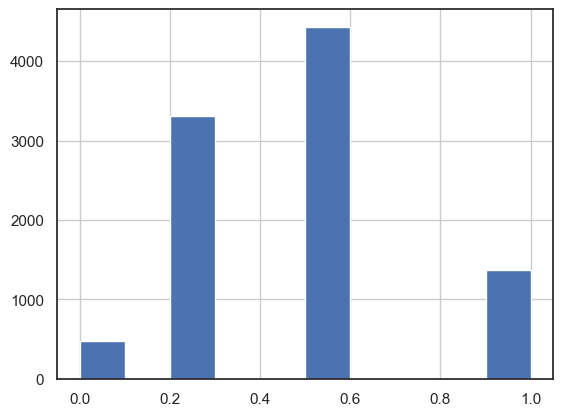

In [294]:
compare_sent['same_3'].hist()
plt.show()

In [454]:
compare_post = score_final.iloc[:,:2]
compare_post['max_1_col_ulmfit'] = score_final['max_1_col']
compare_post['max_2_col_ulmfit'] = score_final['max_2_col']
compare_post['max_3_col_ulmfit'] = score_final['max_3_col']
compare_post['max_1_ulmfit'] = score_final['max_1']
compare_post['max_3_ulmfit'] = score_final['max_3']
compare_post['max_1_col_bert'] = score_final_bert['max_1_col']
compare_post['max_2_col_bert'] = score_final_bert['max_2_col']
compare_post['max_3_col_bert'] = score_final_bert['max_3_col']
compare_post['max_1_bert'] = score_final_bert['max_1']
compare_post['max_3_bert'] = score_final_bert['max_3']

In [455]:
compare_post['same_1'] = compare_post['max_1_col_ulmfit']==compare_post['max_1_col_bert']

In [456]:
compare_post['same_3'] = compare_post.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [457]:
compare_post['same_1'].mean()

0.2015025489669976

In [458]:
compare_post['same_3'].mean()

0.38553796619264824

In [300]:
(compare_post['same_3']>=0.5).mean()

0.5186477059297022

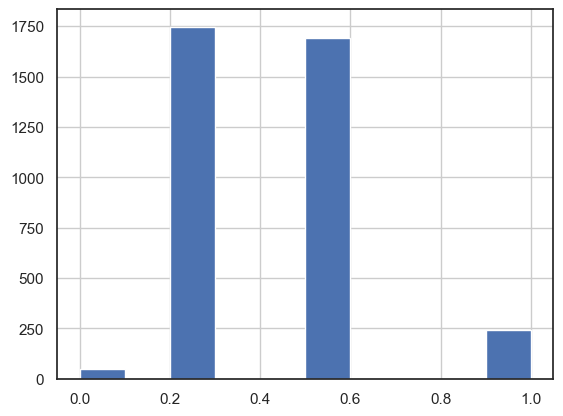

In [301]:
compare_post['same_3'].hist()
plt.show()

In [379]:
from sklearn.metrics.pairwise import cosine_similarity

In [459]:
cs = cosine_similarity(sm_df[classes], sm_df_bert[classes])

In [460]:
compare_sent['cosine_sim'] = np.diagonal(cs)

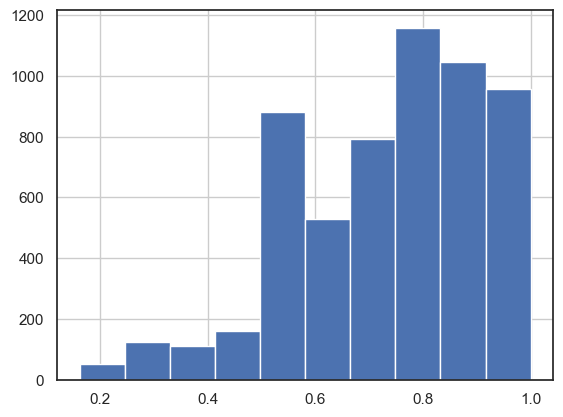

In [467]:
compare_sent[compare_sent.same_3>=0.5]['cosine_sim'].hist()
plt.show()

In [462]:
cs = cosine_similarity(score_final[classes], score_final_bert[classes])

In [463]:
compare_post['cosine_sim'] = np.diagonal(cs)

In [464]:
compare_post

,origin,index,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3,cosine_sim
0,2,51885929339,Criteria iv,Criteria iii,Criteria ii,0.280558,0.813833,Criteria iv,Criteria ii,Criteria vi,0.531683,0.877878,True,0.5,0.805216
1,3,51884357517,Criteria iii,Criteria iv,Criteria ii,0.441306,0.779117,Criteria iv,Criteria iii,Criteria vi,0.509236,0.742402,False,0.5,0.670258
2,8,51883860957,Criteria iv,Criteria vi,Criteria ii,0.228607,0.560199,Criteria i,Criteria iv,Criteria iii,0.289079,0.687324,False,0.2,0.858258
3,9,51884423594,Criteria ii,Criteria iv,Criteria iii,0.401489,0.787524,Criteria iv,Criteria vi,Criteria ii,0.470036,0.846035,False,0.5,0.705522
4,13,51882154188,Criteria iii,Criteria iv,Criteria vi,0.304299,0.730016,Criteria iv,Criteria vi,Criteria ii,0.440501,0.829711,False,0.5,0.776164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,4993,51361633644,Criteria iii,Criteria iv,Criteria vi,0.365005,0.752462,Criteria vi,Criteria iii,Criteria iv,0.461521,0.763086,False,1.0,0.739271
3723,4995,51357996868,Criteria iii,Criteria iv,Criteria vi,0.292644,0.663798,Criteria ii,Criteria i,Criteria iv,0.729162,0.905567,False,0.2,0.492865
3724,4996,51356750697,Criteria iii,Criteria vi,Criteria iv,0.835118,0.946161,Criteria i,Criteria x,Criteria iii,0.271104,0.565897,False,0.2,0.349461
3725,4997,51358508460,Criteria iii,Criteria vi,Criteria iv,0.835118,0.946161,Criteria i,Criteria x,Criteria iii,0.271104,0.565897,False,0.2,0.349461


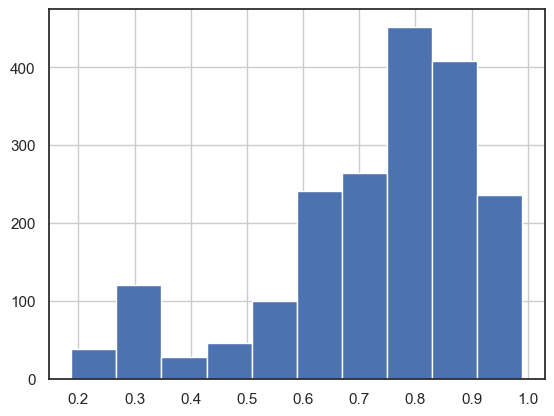

In [466]:
compare_post[compare_post.same_3>=0.5]['cosine_sim'].hist()
plt.show()

In [468]:
compare_sent.to_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences_compare.csv',sep='\t', encoding='utf-8-sig')
compare_post.to_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata_compare.csv',sep='\t', encoding='utf-8-sig')

### Suzhou

In [304]:
sm_df = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [305]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata.csv',sep='\t', index_col = 'Unnamed: 0').reset_index().rename(columns={'level_0':'origin'})

In [306]:
def record_ouv(line, classifier=classifier, vectorizer=vectorizer, classes=classes, k=11):
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k)
    for key, value in predictions:
        line[key] = value

In [307]:
new_dict = {}
for i in range(len(sm_df)):
    new_dict[i]={}
    line = sm_df.iloc[i].copy()
    predictions = predict_rating(line['sentence'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        new_dict[i][key] = value
    if len(new_dict)%100==0:
        print('{}/{} finished'.format(len(new_dict),len(sm_df)))

100/984 finished
200/984 finished
300/984 finished
400/984 finished
500/984 finished
600/984 finished
700/984 finished
800/984 finished
900/984 finished


In [308]:
des_dict = {}
for i in range(len(sm_all_df)):
    des_dict[i]={}
    line = sm_all_df.iloc[i].copy()
    predictions = predict_rating(line['revised_text'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        des_dict[i][key] = value
    if len(des_dict)%100==0:
        print('{}/{} finished'.format(len(des_dict),len(sm_all_df)))

100/3137 finished
200/3137 finished
300/3137 finished
400/3137 finished
500/3137 finished
600/3137 finished
700/3137 finished
800/3137 finished
900/3137 finished
1000/3137 finished
1100/3137 finished
1200/3137 finished
1300/3137 finished
1400/3137 finished
1500/3137 finished
1600/3137 finished
1700/3137 finished
1800/3137 finished
1900/3137 finished
2000/3137 finished
2100/3137 finished
2200/3137 finished
2300/3137 finished
2400/3137 finished
2500/3137 finished
2600/3137 finished
2700/3137 finished
2800/3137 finished
2900/3137 finished
3000/3137 finished
3100/3137 finished


In [312]:
score_df = pd.DataFrame(new_dict).reindex(classes).T
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.104594,0.058130,0.279820,0.128036,0.016812,0.279067,0.043005,0.038831,0.016578,0.033540,0.001587
1,0.056032,0.070969,0.168670,0.097677,0.016396,0.331788,0.055129,0.093043,0.033783,0.073110,0.003402
2,0.021472,0.106980,0.381616,0.188678,0.094129,0.179596,0.007077,0.004498,0.007748,0.008071,0.000134
3,0.126042,0.060049,0.293035,0.140538,0.012537,0.186152,0.063421,0.059563,0.022375,0.035624,0.000663
4,0.098538,0.030404,0.165419,0.079331,0.011728,0.133529,0.160967,0.207680,0.049797,0.060257,0.002351
...,...,...,...,...,...,...,...,...,...,...,...
979,0.048024,0.136803,0.453741,0.143459,0.028587,0.143825,0.013213,0.007045,0.011292,0.013941,0.000071
980,0.048024,0.136803,0.453741,0.143459,0.028587,0.143825,0.013213,0.007045,0.011292,0.013941,0.000071
981,0.579131,0.127127,0.084413,0.162542,0.003232,0.042198,0.000389,0.000444,0.000251,0.000213,0.000058
982,0.088320,0.053277,0.333507,0.125195,0.022723,0.069450,0.126014,0.070678,0.050656,0.059995,0.000186


In [313]:
score_all_df = pd.DataFrame(des_dict).reindex(classes).T
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244
1,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244
2,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244
3,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244
4,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244
...,...,...,...,...,...,...,...,...,...,...,...
3132,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030
3133,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030
3134,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030
3135,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030


In [314]:
a = score_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [315]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([score_df, df1, df2], axis=1).reindex(c, axis=1)

In [316]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.104594,0.058130,0.279820,0.128036,0.016812,0.279067,0.043005,0.038831,0.016578,0.033540,0.001587,0.279820,Criteria iii,0.279067,Criteria vi,0.128036,Criteria iv,0.279820,0.686922
1,0.056032,0.070969,0.168670,0.097677,0.016396,0.331788,0.055129,0.093043,0.033783,0.073110,0.003402,0.331788,Criteria vi,0.168670,Criteria iii,0.097677,Criteria iv,0.331788,0.598135
2,0.021472,0.106980,0.381616,0.188678,0.094129,0.179596,0.007077,0.004498,0.007748,0.008071,0.000134,0.381616,Criteria iii,0.188678,Criteria iv,0.179596,Criteria vi,0.381616,0.749891
3,0.126042,0.060049,0.293035,0.140538,0.012537,0.186152,0.063421,0.059563,0.022375,0.035624,0.000663,0.293035,Criteria iii,0.186152,Criteria vi,0.140538,Criteria iv,0.293035,0.619725
4,0.098538,0.030404,0.165419,0.079331,0.011728,0.133529,0.160967,0.207680,0.049797,0.060257,0.002351,0.207680,Criteria viii,0.165419,Criteria iii,0.160967,Criteria vii,0.207680,0.534065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,0.048024,0.136803,0.453741,0.143459,0.028587,0.143825,0.013213,0.007045,0.011292,0.013941,0.000071,0.453741,Criteria iii,0.143825,Criteria vi,0.143459,Criteria iv,0.453741,0.741025
980,0.048024,0.136803,0.453741,0.143459,0.028587,0.143825,0.013213,0.007045,0.011292,0.013941,0.000071,0.453741,Criteria iii,0.143825,Criteria vi,0.143459,Criteria iv,0.453741,0.741025
981,0.579131,0.127127,0.084413,0.162542,0.003232,0.042198,0.000389,0.000444,0.000251,0.000213,0.000058,0.579131,Criteria i,0.162542,Criteria iv,0.127127,Criteria ii,0.579131,0.868801
982,0.088320,0.053277,0.333507,0.125195,0.022723,0.069450,0.126014,0.070678,0.050656,0.059995,0.000186,0.333507,Criteria iii,0.126014,Criteria vii,0.125195,Criteria iv,0.333507,0.584716


In [317]:
sm_df = sm_df.merge(score_df, how='left', left_index=True, right_index=True)

In [318]:
a = score_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [319]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([score_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [320]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051
1,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051
2,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051
3,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051
4,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161
3133,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161
3134,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161
3135,0.024309,0.016332,0.835118,0.026072,0.008615,0.084970,0.002452,0.001664,0.000337,0.000101,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161


In [321]:
sm_all_df = sm_all_df.merge(score_all_df, how='left', left_index=True, right_index=True)
sm_all_df['valid'] = sm_all_df['revised_text'].apply(lambda x: str(x)!='nan')

In [322]:
sm_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,8,51859675789,1.0,https://live.staticflickr.com/65535/51859675789_2abb735954_c.jpg,https://live.staticflickr.com/65535/51859675789_2abb735954_q.jpg,https://live.staticflickr.com/65535/51859675789_2abb735954_n.jpg,https://live.staticflickr.com/65535/51859675789_0dc586ec53_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,True
1,9,51859339946,1.0,https://live.staticflickr.com/65535/51859339946_9ca193472a_c.jpg,https://live.staticflickr.com/65535/51859339946_9ca193472a_q.jpg,https://live.staticflickr.com/65535/51859339946_9ca193472a_n.jpg,https://live.staticflickr.com/65535/51859339946_cf01cf0229_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,True
2,10,51858385807,1.0,https://live.staticflickr.com/65535/51858385807_aeeb29b536_c.jpg,https://live.staticflickr.com/65535/51858385807_aeeb29b536_q.jpg,https://live.staticflickr.com/65535/51858385807_aeeb29b536_n.jpg,https://live.staticflickr.com/65535/51858385807_bf38fd6ae9_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,True
3,11,51859339546,1.0,https://live.staticflickr.com/65535/51859339546_74e167d9a0_c.jpg,https://live.staticflickr.com/65535/51859339546_74e167d9a0_q.jpg,https://live.staticflickr.com/65535/51859339546_74e167d9a0_n.jpg,https://live.staticflickr.com/65535/51859339546_10dd36c744_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,True
4,12,51858385377,1.0,https://live.staticflickr.com/65535/51858385377_9aef1c02a6_c.jpg,https://live.staticflickr.com/65535/51858385377_9aef1c02a6_q.jpg,https://live.staticflickr.com/65535/51858385377_9aef1c02a6_n.jpg,https://live.staticflickr.com/65535/51858385377_a46f863401_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,4225,38397950426,1.0,https://live.staticflickr.com/4582/38397950426_a4b2f17df4_c.jpg,https://live.staticflickr.com/4582/38397950426_a4b2f17df4_q.jpg,https://live.staticflickr.com/4582/38397950426_a4b2f17df4_n.jpg,https://live.staticflickr.com/4582/38397950426_56393c39ef_o.jpg,28571579@N03,NaN,20171112_IMG_0515,...,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161,False
3133,4226,38397948496,1.0,https://live.staticflickr.com/4517/38397948496_9ebeca6454_c.jpg,https://live.staticflickr.com/4517/38397948496_9ebeca6454_q.jpg,https://live.staticflickr.com/4517/38397948496_9ebeca6454_n.jpg,https://live.staticflickr.com/4517/38397948496_e059e1dfc9_o.jpg,28571579@N03,NaN,20171112_IMG_0518,...,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161,False
3134,4227,38454117381,1.0,https://live.staticflickr.com/4552/38454117381_40a5e9e096_c.jpg,https://live.staticflickr.com/4552/38454117381_40a5e9e096_q.jpg,https://live.staticflickr.com/4552/38454117381_40a5e9e096_n.jpg,https://live.staticflickr.com/4552/38454117381_11eb0b5276_o.jpg,28571579@N03,NaN,20171112_IMG_0531,...,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161,False
3135,4228,38397940256,1.0,https://live.staticflickr.com/4576/38397940256_1e4eb547c5_c.jpg,https://live.staticflickr.com/4576/38397940256_1e4eb547c5_q.jpg,https://live.staticflickr.com/4576/38397940256_1e4eb547c5_n.jpg,https://live.staticflickr.com/4576/38397940256_d2435cc169_o.jpg,28571579@N03,NaN,20171112_IMG_0539,...,0.000030,0.835118,Criteria iii,0.084970,Criteria vi,0.026072,Criteria iv,0.835118,0.946161,F

In [323]:
sm_agg_df = sm_df[classes+['origin']].groupby('origin').mean().reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,8,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,0.314417,0.008244
1,13,0.179543,0.064325,0.261650,0.138205,0.009879,0.201400,0.053668,0.049119,0.014844,0.026549,0.000817
2,16,0.179543,0.064325,0.261650,0.138205,0.009879,0.201400,0.053668,0.049119,0.014844,0.026549,0.000817
3,23,0.094989,0.110768,0.220466,0.122650,0.008431,0.402479,0.007570,0.014587,0.005225,0.011958,0.000876
4,104,0.104594,0.058130,0.279820,0.128036,0.016812,0.279067,0.043005,0.038831,0.016578,0.033540,0.001587
...,...,...,...,...,...,...,...,...,...,...,...,...
749,4129,0.301006,0.122344,0.223976,0.162998,0.013824,0.129075,0.025927,0.007752,0.005951,0.006979,0.000167
750,4136,0.007777,0.081635,0.602493,0.027598,0.015850,0.264353,0.000118,0.000057,0.000051,0.000057,0.000011
751,4137,0.007777,0.081635,0.602493,0.027598,0.015850,0.264353,0.000118,0.000057,0.000051,0.000057,0.000011
752,4139,0.052357,0.029437,0.189260,0.069971,0.014008,0.043776,0.288277,0.165771,0.071021,0.075644,0.000478


In [324]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [325]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [326]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','sentence']].groupby('origin').count().reset_index()['sentence']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,8,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,...,0.008244,0.314417,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,1
1,13,0.179543,0.064325,0.261650,0.138205,0.009879,0.201400,0.053668,0.049119,0.014844,...,0.000817,0.261650,Criteria iii,0.201400,Criteria vi,0.179543,Criteria i,0.261650,0.642593,1
2,16,0.179543,0.064325,0.261650,0.138205,0.009879,0.201400,0.053668,0.049119,0.014844,...,0.000817,0.261650,Criteria iii,0.201400,Criteria vi,0.179543,Criteria i,0.261650,0.642593,1
3,23,0.094989,0.110768,0.220466,0.122650,0.008431,0.402479,0.007570,0.014587,0.005225,...,0.000876,0.402479,Criteria vi,0.220466,Criteria iii,0.122650,Criteria iv,0.402479,0.745595,1
4,104,0.104594,0.058130,0.279820,0.128036,0.016812,0.279067,0.043005,0.038831,0.016578,...,0.001587,0.279820,Criteria iii,0.279067,Criteria vi,0.128036,Criteria iv,0.279820,0.686922,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,4129,0.301006,0.122344,0.223976,0.162998,0.013824,0.129075,0.025927,0.007752,0.005951,...,0.000167,0.301006,Criteria i,0.223976,Criteria iii,0.162998,Criteria iv,0.301006,0.687980,3
750,4136,0.007777,0.081635,0.602493,0.027598,0.015850,0.264353,0.000118,0.000057,0.000051,...,0.000011,0.602493,Criteria iii,0.264353,Criteria vi,0.081635,Criteria ii,0.602493,0.948481,1
751,4137,0.007777,0.081635,0.602493,0.027598,0.015850,0.264353,0.000118,0.000057,0.000051,...,0.000011,0.602493,Criteria iii,0.264353,Criteria vi,0.081635,Criteria ii,0.602493,0.948481,1
752,4139,0.052357,0.029437,0.189260,0.069971,0.014008,0.043776,0.288277,0.165771,0.071021,...,0.000478,0.288277,Criteria vii,0.189260,Criteria iii,0.165771,Criteria viii,0.288277,0.643308,2


In [327]:
score_df['max_1_col'].value_counts()

Criteria iii     770
Criteria vi      117
Criteria vii      38
Criteria i        32
Criteria iv       12
Criteria ii        5
Criteria x         4
Criteria viii      2
Criteria v         2
Criteria ix        2
Name: max_1_col, dtype: int64

In [328]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria iii     921
Criteria vi      836
Criteria ii      620
Criteria iv      344
Criteria i        82
Criteria vii      70
Criteria viii     28
Criteria x        23
Criteria v        16
Criteria ix       12
dtype: int64

In [329]:
sm_all_df[sm_all_df.valid]['max_1_col'].value_counts()

Criteria iii    895
Criteria vi     232
Criteria i       69
Criteria vii     68
Criteria x       15
Criteria ii       5
Criteria iv       3
Name: max_1_col, dtype: int64

In [330]:
pd.concat([score_all_df[sm_all_df.valid]['max_1_col'],
           score_all_df[sm_all_df.valid]['max_2_col'],
           score_all_df[sm_all_df.valid]['max_3_col']]).value_counts()

Criteria iii     1124
Criteria vi      1124
Criteria ii       613
Criteria iv       458
Criteria i        269
Criteria vii      100
Criteria x         79
Criteria viii      75
Criteria v         10
Criteria ix         9
dtype: int64

In [331]:
score_agg_df['max_1_col'].value_counts()

Criteria iii    668
Criteria vi      57
Criteria vii     12
Criteria i       11
Criteria ii       3
Criteria iv       2
Criteria x        1
Name: max_1_col, dtype: int64

In [332]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria iii     743
Criteria vi      715
Criteria ii      504
Criteria iv      203
Criteria vii      44
Criteria i        32
Criteria x         9
Criteria viii      8
Criteria v         3
Criteria ix        1
dtype: int64

In [333]:
sm_df['max_1']

0      0.279820
1      0.331788
2      0.381616
3      0.293035
4      0.207680
         ...   
979    0.453741
980    0.453741
981    0.579131
982    0.333507
983    0.333507
Name: max_1, Length: 984, dtype: float64

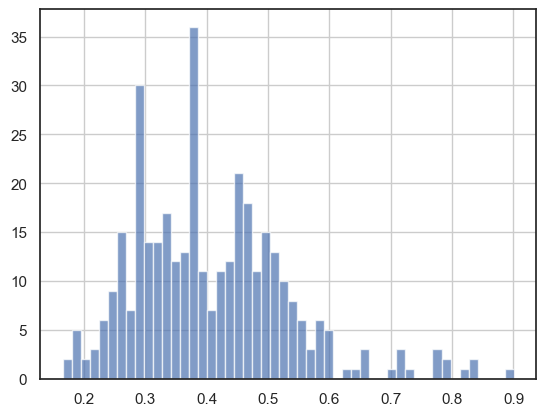

In [334]:
import seaborn as sns
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)
plt.show()

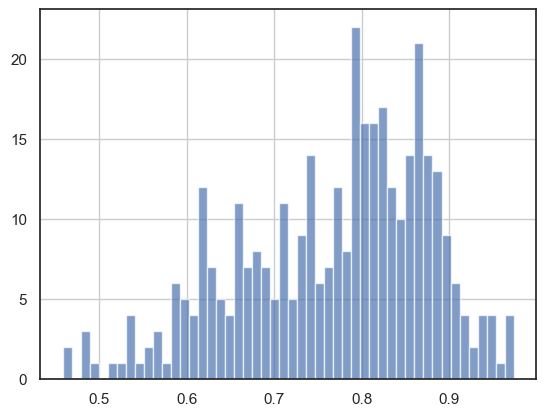

In [335]:
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)
plt.show()

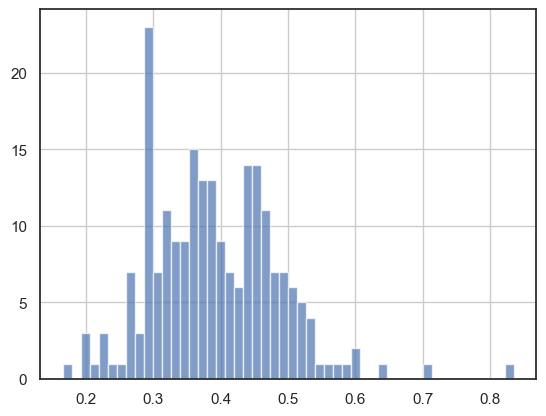

In [336]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_1'].hist(alpha=.7, bins=50)
plt.show()

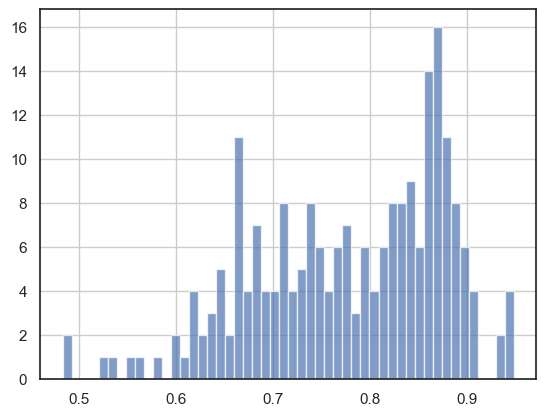

In [337]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_3'].hist(alpha=.7, bins=50)
plt.show()

In [338]:
compare = score_agg_df.merge(sm_all_df, how = 'left', left_on='origin', right_on='origin')

In [339]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [340]:
compare['max_1_eq'].mean()

0.9350132625994695

In [341]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.644927536231884

In [342]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [343]:
compare['max_3_eq'].mean()

0.9594164456233422

In [344]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.7782608695652175

In [345]:
len(score_df[(score_df.max_3>0.8) & (score_df.max_1>1./3)])

495

In [346]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [347]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [348]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,8,0.036616,0.006713,0.033030,0.016527,0.002198,0.038865,0.191097,0.293537,0.058757,...,Criteria x,0.293537,Criteria viii,0.191097,Criteria vii,0.314417,0.799051,True,True,1.0
1,13,0.179543,0.064325,0.261650,0.138205,0.009879,0.201400,0.053668,0.049119,0.014844,...,Criteria iii,0.201400,Criteria vi,0.179543,Criteria i,0.261650,0.642593,True,True,1.0
2,16,0.179543,0.064325,0.261650,0.138205,0.009879,0.201400,0.053668,0.049119,0.014844,...,Criteria iii,0.201400,Criteria vi,0.179543,Criteria i,0.261650,0.642593,True,True,1.0
3,23,0.094989,0.110768,0.220466,0.122650,0.008431,0.402479,0.007570,0.014587,0.005225,...,Criteria vi,0.220466,Criteria iii,0.122650,Criteria iv,0.402479,0.745595,True,True,1.0
4,104,0.104594,0.058130,0.279820,0.128036,0.016812,0.279067,0.043005,0.038831,0.016578,...,Criteria iii,0.279067,Criteria vi,0.128036,Criteria iv,0.279820,0.686922,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,4129,0.301006,0.122344,0.223976,0.162998,0.013824,0.129075,0.025927,0.007752,0.005951,...,Criteria i,0.180936,Criteria iv,0.139311,Criteria iii,0.404491,0.724738,True,True,1.0
750,4136,0.007777,0.081635,0.602493,0.027598,0.015850,0.264353,0.000118,0.000057,0.000051,...,Criteria iii,0.264353,Criteria vi,0.081635,Criteria ii,0.602493,0.948481,True,True,1.0
751,4137,0.007777,0.081635,0.602493,0.027598,0.015850,0.264353,0.000118,0.000057,0.000051,...,Criteria iii,0.264353,Criteria vi,0.081635,Criteria ii,0.602493,0.948481,True,True,1.0
752,4139,0.052357,0.029437,0.189260,0.069971,0.014008,0.043776,0.288277,0.165771,0.071021,...,Criteria vii,0.208068,Criteria viii,0.079734,Criteria ix,0.522356,0.810158,True,True,0.5


In [349]:
score_final = sm_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [350]:
score_final

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,8,51859675789,1.0,https://live.staticflickr.com/65535/51859675789_2abb735954_c.jpg,https://live.staticflickr.com/65535/51859675789_2abb735954_q.jpg,https://live.staticflickr.com/65535/51859675789_2abb735954_n.jpg,https://live.staticflickr.com/65535/51859675789_0dc586ec53_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.191097,Criteria vii,0.314417,0.799051,True,Criteria x,Criteria viii,Criteria vii,True,1.0
1,9,51859339946,1.0,https://live.staticflickr.com/65535/51859339946_9ca193472a_c.jpg,https://live.staticflickr.com/65535/51859339946_9ca193472a_q.jpg,https://live.staticflickr.com/65535/51859339946_9ca193472a_n.jpg,https://live.staticflickr.com/65535/51859339946_cf01cf0229_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.191097,Criteria vii,0.314417,0.799051,True,NaN,NaN,NaN,NaN,NaN
2,10,51858385807,1.0,https://live.staticflickr.com/65535/51858385807_aeeb29b536_c.jpg,https://live.staticflickr.com/65535/51858385807_aeeb29b536_q.jpg,https://live.staticflickr.com/65535/51858385807_aeeb29b536_n.jpg,https://live.staticflickr.com/65535/51858385807_bf38fd6ae9_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.191097,Criteria vii,0.314417,0.799051,True,NaN,NaN,NaN,NaN,NaN
3,11,51859339546,1.0,https://live.staticflickr.com/65535/51859339546_74e167d9a0_c.jpg,https://live.staticflickr.com/65535/51859339546_74e167d9a0_q.jpg,https://live.staticflickr.com/65535/51859339546_74e167d9a0_n.jpg,https://live.staticflickr.com/65535/51859339546_10dd36c744_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.191097,Criteria vii,0.314417,0.799051,True,NaN,NaN,NaN,NaN,NaN
4,12,51858385377,1.0,https://live.staticflickr.com/65535/51858385377_9aef1c02a6_c.jpg,https://live.staticflickr.com/65535/51858385377_9aef1c02a6_q.jpg,https://live.staticflickr.com/65535/51858385377_9aef1c02a6_n.jpg,https://live.staticflickr.com/65535/51858385377_a46f863401_o.jpg,57210421@N04,"Beijing, China",灭渡桥,...,0.191097,Criteria vii,0.314417,0.799051,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,4225,38397950426,1.0,https://live.staticflickr.com/4582/38397950426_a4b2f17df4_c.jpg,https://live.staticflickr.com/4582/38397950426_a4b2f17df4_q.jpg,https://live.staticflickr.com/4582/38397950426_a4b2f17df4_n.jpg,https://live.staticflickr.com/4582/38397950426_56393c39ef_o.jpg,28571579@N03,NaN,20171112_IMG_0515,...,0.026072,Criteria iv,0.835118,0.946161,False,NaN,NaN,NaN,NaN,NaN
3133,4226,38397948496,1.0,https://live.staticflickr.com/4517/38397948496_9ebeca6454_c.jpg,https://live.staticflickr.com/4517/38397948496_9ebeca6454_q.jpg,https://live.staticflickr.com/4517/38397948496_9ebeca6454_n.jpg,https://live.staticflickr.com/4517/38397948496_e059e1dfc9_o.jpg,28571579@N03,NaN,20171112_IMG_0518,...,0.026072,Criteria iv,0.835118,0.946161,False,NaN,NaN,NaN,NaN,NaN
3134,4227,38454117381,1.0,https://live.staticflickr.com/4552/38454117381_40a5e9e096_c.jpg,https://live.staticflickr.com/4552/38454117381_40a5e9e096_q.jpg,https://live.staticflickr.com/4552/38454117381_40a5e9e096_n.jpg,https://live.staticflickr.com/4552/38454117381_11eb0b5276_o.jpg,28571579@N03,NaN,20171112_IMG_0531,...,0.026072,Criteria iv,0.835118,0.946161,False,NaN,NaN,NaN,NaN,NaN
3135,4228,38397940256,1.0,https://live.staticflickr.com/4576/38397940256_1e4eb547c5_c.jpg,https://live.staticflickr.com/4576/38397940256_1e4eb547c5_q.jpg,https://live.staticflickr.com/4576/38397940256_1e4eb547c5_n.jpg,https://live.staticflickr.com/4576/38397940256_d2435cc169_o.jpg,28571579@N03,NaN,20171112_IMG_0539,...,0.026072,Criteria iv,0.835118,0.946161,False,NaN,NaN,NaN,NaN,NaN


In [351]:
sm_df.to_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig')

In [469]:
sm_df=pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final=pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

In [470]:
sm_df_bert = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final_bert = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

<ipython-input-470-5421ceb0d8b8>:2: DtypeWarning: Columns (824,825,826,827) have mixed types. Specify dtype option on import or set low_memory=False.
  score_final_bert = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')


In [471]:
compare_sent = sm_df.iloc[:,:4]
compare_sent['max_1_col_ulmfit'] = sm_df['max_1_col']
compare_sent['max_2_col_ulmfit'] = sm_df['max_2_col']
compare_sent['max_3_col_ulmfit'] = sm_df['max_3_col']
compare_sent['max_1_ulmfit'] = sm_df['max_1']
compare_sent['max_3_ulmfit'] = sm_df['max_3']
compare_sent['max_1_col_bert'] = sm_df_bert['max_1_col']
compare_sent['max_2_col_bert'] = sm_df_bert['max_2_col']
compare_sent['max_3_col_bert'] = sm_df_bert['max_3_col']
compare_sent['max_1_bert'] = sm_df_bert['max_1']
compare_sent['max_3_bert'] = sm_df_bert['max_3']

In [472]:
compare_sent['same_1'] = compare_sent['max_1_col_ulmfit']==compare_sent['max_1_col_bert']

In [473]:
compare_sent['same_3'] = compare_sent.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [474]:
compare_sent['same_1'].mean()

0.21951219512195122

In [475]:
(compare_sent['same_3']>=0.5).mean()

0.7296747967479674

In [358]:
compare_sent[compare_sent['same_3']>=0.5]

,index,sentence,origin,lang,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3
2,5,and a family (in the background),131,en,Criteria iii,Criteria iv,Criteria vi,0.381616,0.749891,Criteria iv,Criteria iii,Criteria v,0.330711,0.760191,False,0.5
6,9,It has title of A streetlamp in SIP,137,en,Criteria vi,Criteria iii,Criteria iv,0.322159,0.666619,Criteria iv,Criteria i,Criteria iii,0.491229,0.783081,False,0.5
7,10,It has title of The classic Soochow-style brunch,138,en,Criteria i,Criteria iv,Criteria iii,0.362317,0.734053,Criteria vi,Criteria iv,Criteria iii,0.477917,0.773208,False,0.5
8,11,"It has tags of chenyang, suzhou, jiangsu, peoplesrepublicofchina",349,en,Criteria iii,Criteria vi,Criteria iv,0.509157,0.825236,Criteria iii,Criteria vi,Criteria iv,0.333751,0.768451,True,1.0
9,12,"It has tags of suzhou, jiangsu, peoplesrepublicofchina, chenyang",350,en,Criteria iii,Criteria vi,Criteria ii,0.480951,0.821939,Criteria vi,Criteria iii,Criteria iv,0.443253,0.770803,False,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,1761,"It has tags of suzhoushi, jiangsusheng, china, cn",4116,other,Criteria iii,Criteria vi,Criteria iv,0.453741,0.741025,Criteria iii,Criteria ii,Criteria vi,0.247030,0.609589,True,0.5
980,1763,"It has tags of suzhoushi, jiangsusheng, china, cn",4117,other,Criteria iii,Criteria vi,Criteria iv,0.453741,0.741025,Criteria iii,Criteria ii,Criteria vi,0.247030,0.609589,True,0.5
981,1764,Canglang Pavilion 20171120 adam0730,4129,other,Criteria i,Criteria iv,Criteria ii,0.579131,0.868801,Criteria i,Criteria iv,Criteria ii,0.619855,0.796199,True,1.0
982,1773,It has tags of chinasuzhou,4139,other,Criteria iii,Criteria vii,Criteria iv,0.333507,0.584716,Criteria iii,Criteria vi,Criteria iv,0.398199,0.672273,True,0.5


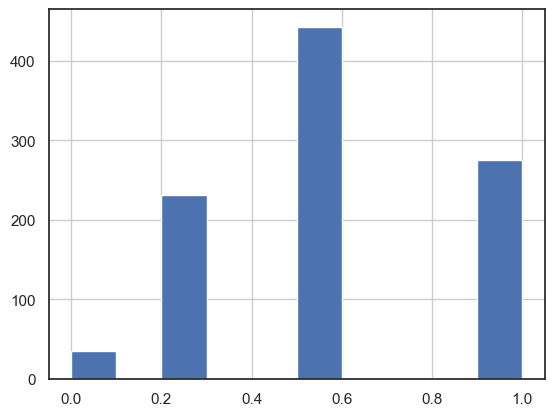

In [476]:
compare_sent['same_3'].hist()
plt.show()

In [477]:
compare_post = score_final.iloc[:,:2]
compare_post['max_1_col_ulmfit'] = score_final['max_1_col']
compare_post['max_2_col_ulmfit'] = score_final['max_2_col']
compare_post['max_3_col_ulmfit'] = score_final['max_3_col']
compare_post['max_1_ulmfit'] = score_final['max_1']
compare_post['max_3_ulmfit'] = score_final['max_3']
compare_post['max_1_col_bert'] = score_final_bert['max_1_col']
compare_post['max_2_col_bert'] = score_final_bert['max_2_col']
compare_post['max_3_col_bert'] = score_final_bert['max_3_col']
compare_post['max_1_bert'] = score_final_bert['max_1']
compare_post['max_3_bert'] = score_final_bert['max_3']

In [478]:
compare_post['same_1'] = compare_post['max_1_col_ulmfit']==compare_post['max_1_col_bert']

In [479]:
compare_post['same_3'] = compare_post.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [480]:
compare_post['same_1'].mean()

0.10583359897991712

In [481]:
compare_post['same_3'].mean()

0.3478163850812878

In [482]:
(compare_post['same_3']>=0.5).mean()

0.3190946764424609

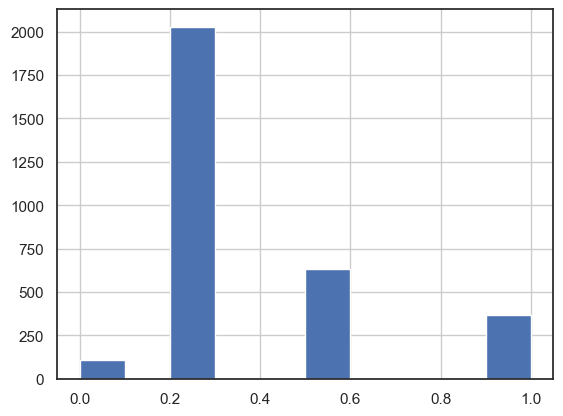

In [366]:
compare_post['same_3'].hist()
plt.show()

In [379]:
from sklearn.metrics.pairwise import cosine_similarity

In [483]:
cs = cosine_similarity(sm_df[classes], sm_df_bert[classes])

In [484]:
compare_sent['cosine_sim'] = np.diagonal(cs)

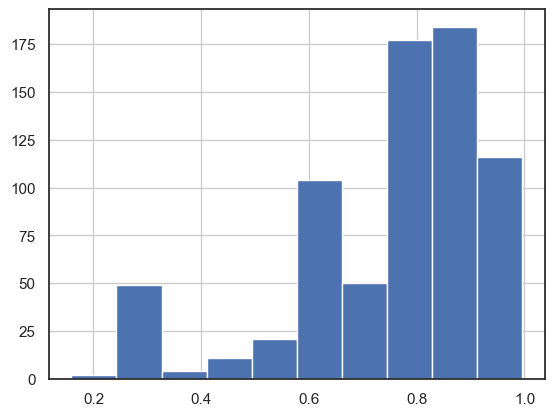

In [486]:
compare_sent[compare_sent.same_3>=0.5]['cosine_sim'].hist()
plt.show()

In [487]:
cs = cosine_similarity(score_final[classes], score_final_bert[classes])

In [488]:
compare_post['cosine_sim'] = np.diagonal(cs)

In [489]:
compare_post

,origin,index,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3,cosine_sim
0,8,51859675789,Criteria x,Criteria viii,Criteria vii,0.314417,0.799051,Criteria ix,Criteria x,Criteria viii,0.592425,0.898150,False,0.5,0.455594
1,9,51859339946,Criteria x,Criteria viii,Criteria vii,0.314417,0.799051,Criteria ix,Criteria x,Criteria viii,0.592425,0.898150,False,0.5,0.455594
2,10,51858385807,Criteria x,Criteria viii,Criteria vii,0.314417,0.799051,Criteria ix,Criteria x,Criteria viii,0.592425,0.898150,False,0.5,0.455594
3,11,51859339546,Criteria x,Criteria viii,Criteria vii,0.314417,0.799051,Criteria ix,Criteria x,Criteria viii,0.592425,0.898150,False,0.5,0.455594
4,12,51858385377,Criteria x,Criteria viii,Criteria vii,0.314417,0.799051,Criteria ix,Criteria x,Criteria viii,0.592425,0.898150,False,0.5,0.455594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,4225,38397950426,Criteria iii,Criteria vi,Criteria iv,0.835118,0.946161,Criteria i,Criteria x,Criteria iii,0.270940,0.565778,False,0.2,0.349416
3133,4226,38397948496,Criteria iii,Criteria vi,Criteria iv,0.835118,0.946161,Criteria i,Criteria x,Criteria iii,0.270940,0.565778,False,0.2,0.349416
3134,4227,38454117381,Criteria iii,Criteria vi,Criteria iv,0.835118,0.946161,Criteria i,Criteria x,Criteria iii,0.270940,0.565778,False,0.2,0.349416
3135,4228,38397940256,Criteria iii,Criteria vi,Criteria iv,0.835118,0.946161,Criteria i,Criteria x,Criteria iii,0.270940,0.565778,False,0.2,0.349416


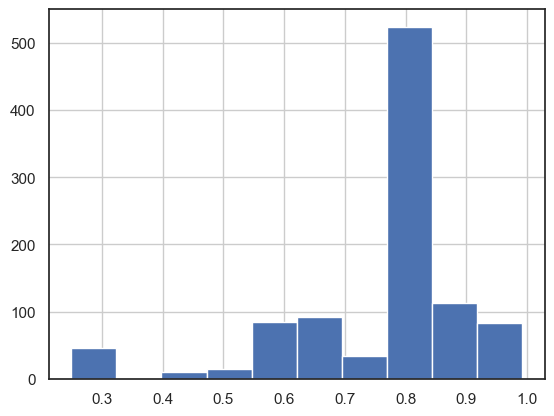

In [490]:
compare_post[compare_post.same_3>=0.5]['cosine_sim'].hist()
plt.show()

In [491]:
compare_sent.to_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences_compare.csv',sep='\t', encoding='utf-8-sig')
compare_post.to_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_compare.csv',sep='\t', encoding='utf-8-sig')

### Venice_Large

In [492]:
sm_df = pd.read_csv('../../../Venice_Flickr/data_storage/images/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [498]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/data_storage/images/metadata.csv',sep='\t', index_col = 'Unnamed: 0').reset_index().rename(columns={'level_0':'origin'})

In [494]:
def record_ouv(line, classifier=classifier, vectorizer=vectorizer, classes=classes, k=11):
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k)
    for key, value in predictions:
        line[key] = value

In [495]:
new_dict = {}
for i in range(len(sm_df)):
    new_dict[i]={}
    line = sm_df.iloc[i].copy()
    predictions = predict_rating(line['sentence'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        new_dict[i][key] = value
    if len(new_dict)%100==0:
        print('{}/{} finished'.format(len(new_dict),len(sm_df)))

100/171024 finished
200/171024 finished
300/171024 finished
400/171024 finished
500/171024 finished
600/171024 finished
700/171024 finished
800/171024 finished
900/171024 finished
1000/171024 finished
1100/171024 finished
1200/171024 finished
1300/171024 finished
1400/171024 finished
1500/171024 finished
1600/171024 finished
1700/171024 finished
1800/171024 finished
1900/171024 finished
2000/171024 finished
2100/171024 finished
2200/171024 finished
2300/171024 finished
2400/171024 finished
2500/171024 finished
2600/171024 finished
2700/171024 finished
2800/171024 finished
2900/171024 finished
3000/171024 finished
3100/171024 finished
3200/171024 finished
3300/171024 finished
3400/171024 finished
3500/171024 finished
3600/171024 finished
3700/171024 finished
3800/171024 finished
3900/171024 finished
4000/171024 finished
4100/171024 finished
4200/171024 finished
4300/171024 finished
4400/171024 finished
4500/171024 finished
4600/171024 finished
4700/171024 finished
4800/171024 finished
4

37900/171024 finished
38000/171024 finished
38100/171024 finished
38200/171024 finished
38300/171024 finished
38400/171024 finished
38500/171024 finished
38600/171024 finished
38700/171024 finished
38800/171024 finished
38900/171024 finished
39000/171024 finished
39100/171024 finished
39200/171024 finished
39300/171024 finished
39400/171024 finished
39500/171024 finished
39600/171024 finished
39700/171024 finished
39800/171024 finished
39900/171024 finished
40000/171024 finished
40100/171024 finished
40200/171024 finished
40300/171024 finished
40400/171024 finished
40500/171024 finished
40600/171024 finished
40700/171024 finished
40800/171024 finished
40900/171024 finished
41000/171024 finished
41100/171024 finished
41200/171024 finished
41300/171024 finished
41400/171024 finished
41500/171024 finished
41600/171024 finished
41700/171024 finished
41800/171024 finished
41900/171024 finished
42000/171024 finished
42100/171024 finished
42200/171024 finished
42300/171024 finished
42400/1710

75200/171024 finished
75300/171024 finished
75400/171024 finished
75500/171024 finished
75600/171024 finished
75700/171024 finished
75800/171024 finished
75900/171024 finished
76000/171024 finished
76100/171024 finished
76200/171024 finished
76300/171024 finished
76400/171024 finished
76500/171024 finished
76600/171024 finished
76700/171024 finished
76800/171024 finished
76900/171024 finished
77000/171024 finished
77100/171024 finished
77200/171024 finished
77300/171024 finished
77400/171024 finished
77500/171024 finished
77600/171024 finished
77700/171024 finished
77800/171024 finished
77900/171024 finished
78000/171024 finished
78100/171024 finished
78200/171024 finished
78300/171024 finished
78400/171024 finished
78500/171024 finished
78600/171024 finished
78700/171024 finished
78800/171024 finished
78900/171024 finished
79000/171024 finished
79100/171024 finished
79200/171024 finished
79300/171024 finished
79400/171024 finished
79500/171024 finished
79600/171024 finished
79700/1710

111900/171024 finished
112000/171024 finished
112100/171024 finished
112200/171024 finished
112300/171024 finished
112400/171024 finished
112500/171024 finished
112600/171024 finished
112700/171024 finished
112800/171024 finished
112900/171024 finished
113000/171024 finished
113100/171024 finished
113200/171024 finished
113300/171024 finished
113400/171024 finished
113500/171024 finished
113600/171024 finished
113700/171024 finished
113800/171024 finished
113900/171024 finished
114000/171024 finished
114100/171024 finished
114200/171024 finished
114300/171024 finished
114400/171024 finished
114500/171024 finished
114600/171024 finished
114700/171024 finished
114800/171024 finished
114900/171024 finished
115000/171024 finished
115100/171024 finished
115200/171024 finished
115300/171024 finished
115400/171024 finished
115500/171024 finished
115600/171024 finished
115700/171024 finished
115800/171024 finished
115900/171024 finished
116000/171024 finished
116100/171024 finished
116200/1710

147600/171024 finished
147700/171024 finished
147800/171024 finished
147900/171024 finished
148000/171024 finished
148100/171024 finished
148200/171024 finished
148300/171024 finished
148400/171024 finished
148500/171024 finished
148600/171024 finished
148700/171024 finished
148800/171024 finished
148900/171024 finished
149000/171024 finished
149100/171024 finished
149200/171024 finished
149300/171024 finished
149400/171024 finished
149500/171024 finished
149600/171024 finished
149700/171024 finished
149800/171024 finished
149900/171024 finished
150000/171024 finished
150100/171024 finished
150200/171024 finished
150300/171024 finished
150400/171024 finished
150500/171024 finished
150600/171024 finished
150700/171024 finished
150800/171024 finished
150900/171024 finished
151000/171024 finished
151100/171024 finished
151200/171024 finished
151300/171024 finished
151400/171024 finished
151500/171024 finished
151600/171024 finished
151700/171024 finished
151800/171024 finished
151900/1710

In [499]:
des_dict = {}
for i in range(len(sm_all_df)):
    des_dict[i]={}
    line = sm_all_df.iloc[i].copy()
    predictions = predict_rating(line['revised_text'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        des_dict[i][key] = value
    if len(des_dict)%100==0:
        print('{}/{} finished'.format(len(des_dict),len(sm_all_df)))

100/80963 finished
200/80963 finished
300/80963 finished
400/80963 finished
500/80963 finished
600/80963 finished
700/80963 finished
800/80963 finished
900/80963 finished
1000/80963 finished
1100/80963 finished
1200/80963 finished
1300/80963 finished
1400/80963 finished
1500/80963 finished
1600/80963 finished
1700/80963 finished
1800/80963 finished
1900/80963 finished
2000/80963 finished
2100/80963 finished
2200/80963 finished
2300/80963 finished
2400/80963 finished
2500/80963 finished
2600/80963 finished
2700/80963 finished
2800/80963 finished
2900/80963 finished
3000/80963 finished
3100/80963 finished
3200/80963 finished
3300/80963 finished
3400/80963 finished
3500/80963 finished
3600/80963 finished
3700/80963 finished
3800/80963 finished
3900/80963 finished
4000/80963 finished
4100/80963 finished
4200/80963 finished
4300/80963 finished
4400/80963 finished
4500/80963 finished
4600/80963 finished
4700/80963 finished
4800/80963 finished
4900/80963 finished
5000/80963 finished
5100/8096

39700/80963 finished
39800/80963 finished
39900/80963 finished
40000/80963 finished
40100/80963 finished
40200/80963 finished
40300/80963 finished
40400/80963 finished
40500/80963 finished
40600/80963 finished
40700/80963 finished
40800/80963 finished
40900/80963 finished
41000/80963 finished
41100/80963 finished
41200/80963 finished
41300/80963 finished
41400/80963 finished
41500/80963 finished
41600/80963 finished
41700/80963 finished
41800/80963 finished
41900/80963 finished
42000/80963 finished
42100/80963 finished
42200/80963 finished
42300/80963 finished
42400/80963 finished
42500/80963 finished
42600/80963 finished
42700/80963 finished
42800/80963 finished
42900/80963 finished
43000/80963 finished
43100/80963 finished
43200/80963 finished
43300/80963 finished
43400/80963 finished
43500/80963 finished
43600/80963 finished
43700/80963 finished
43800/80963 finished
43900/80963 finished
44000/80963 finished
44100/80963 finished
44200/80963 finished
44300/80963 finished
44400/80963 f

78800/80963 finished
78900/80963 finished
79000/80963 finished
79100/80963 finished
79200/80963 finished
79300/80963 finished
79400/80963 finished
79500/80963 finished
79600/80963 finished
79700/80963 finished
79800/80963 finished
79900/80963 finished
80000/80963 finished
80100/80963 finished
80200/80963 finished
80300/80963 finished
80400/80963 finished
80500/80963 finished
80600/80963 finished
80700/80963 finished
80800/80963 finished
80900/80963 finished


In [500]:
score_df = pd.DataFrame(new_dict).reindex(classes).T
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.181625,0.064852,0.250929,0.127421,0.009266,0.196136,0.049570,0.079567,0.016884,0.022925,0.000824
1,0.200316,0.065371,0.280426,0.163337,0.009722,0.211595,0.026202,0.025634,0.007318,0.009731,0.000350
2,0.023386,0.041048,0.650610,0.120257,0.031732,0.123854,0.004549,0.002000,0.001533,0.001002,0.000028
3,0.080087,0.051694,0.216419,0.101298,0.018550,0.212157,0.123733,0.054316,0.043083,0.097148,0.001515
4,0.011231,0.092816,0.606865,0.129320,0.083559,0.070361,0.001795,0.001056,0.001579,0.001387,0.000032
...,...,...,...,...,...,...,...,...,...,...,...
171019,0.020026,0.357152,0.331064,0.177906,0.024876,0.083381,0.001122,0.001206,0.001620,0.001590,0.000056
171020,0.122292,0.060564,0.283526,0.135095,0.010868,0.273299,0.046704,0.035098,0.012026,0.019668,0.000860
171021,0.020823,0.311447,0.365819,0.190683,0.026340,0.077438,0.001554,0.001953,0.002185,0.001698,0.000060
171022,0.058224,0.054545,0.307528,0.141623,0.015750,0.407372,0.005190,0.003834,0.002232,0.003392,0.000310


In [501]:
score_all_df = pd.DataFrame(des_dict).reindex(classes).T
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.300038,0.105972,0.110439,0.391179,0.042873,0.043235,0.002022,0.001575,0.001025,0.001220,0.000422
1,0.300537,0.105456,0.111514,0.387872,0.043060,0.045290,0.002039,0.001567,0.001015,0.001215,0.000434
2,0.183531,0.225481,0.083111,0.449886,0.008262,0.042647,0.002100,0.002684,0.001059,0.001152,0.000087
3,0.085485,0.132468,0.205980,0.378402,0.047569,0.071661,0.040116,0.015467,0.009485,0.013226,0.000141
4,0.045470,0.187583,0.247151,0.351008,0.074293,0.075992,0.007469,0.002897,0.003285,0.004723,0.000129
...,...,...,...,...,...,...,...,...,...,...,...
80958,0.014668,0.161494,0.416799,0.236805,0.074207,0.085732,0.002166,0.002078,0.003267,0.002727,0.000056
80959,0.025120,0.297634,0.334180,0.136499,0.015375,0.185791,0.001277,0.001423,0.001244,0.001374,0.000083
80960,0.027727,0.222477,0.365697,0.173320,0.017452,0.184820,0.001975,0.002437,0.002078,0.001947,0.000069
80961,0.049469,0.091807,0.350125,0.163804,0.015471,0.322296,0.002075,0.001710,0.001439,0.001700,0.000105


In [502]:
a = score_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [503]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([score_df, df1, df2], axis=1).reindex(c, axis=1)

In [504]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.181625,0.064852,0.250929,0.127421,0.009266,0.196136,0.049570,0.079567,0.016884,0.022925,0.000824,0.250929,Criteria iii,0.196136,Criteria vi,0.181625,Criteria i,0.250929,0.628690
1,0.200316,0.065371,0.280426,0.163337,0.009722,0.211595,0.026202,0.025634,0.007318,0.009731,0.000350,0.280426,Criteria iii,0.211595,Criteria vi,0.200316,Criteria i,0.280426,0.692337
2,0.023386,0.041048,0.650610,0.120257,0.031732,0.123854,0.004549,0.002000,0.001533,0.001002,0.000028,0.650610,Criteria iii,0.123854,Criteria vi,0.120257,Criteria iv,0.650610,0.894722
3,0.080087,0.051694,0.216419,0.101298,0.018550,0.212157,0.123733,0.054316,0.043083,0.097148,0.001515,0.216419,Criteria iii,0.212157,Criteria vi,0.123733,Criteria vii,0.216419,0.552309
4,0.011231,0.092816,0.606865,0.129320,0.083559,0.070361,0.001795,0.001056,0.001579,0.001387,0.000032,0.606865,Criteria iii,0.129320,Criteria iv,0.092816,Criteria ii,0.606865,0.829000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171019,0.020026,0.357152,0.331064,0.177906,0.024876,0.083381,0.001122,0.001206,0.001620,0.001590,0.000056,0.357152,Criteria ii,0.331064,Criteria iii,0.177906,Criteria iv,0.357152,0.866123
171020,0.122292,0.060564,0.283526,0.135095,0.010868,0.273299,0.046704,0.035098,0.012026,0.019668,0.000860,0.283526,Criteria iii,0.273299,Criteria vi,0.135095,Criteria iv,0.283526,0.691920
171021,0.020823,0.311447,0.365819,0.190683,0.026340,0.077438,0.001554,0.001953,0.002185,0.001698,0.000060,0.365819,Criteria iii,0.311447,Criteria ii,0.190683,Criteria iv,0.365819,0.867949
171022,0.058224,0.054545,0.307528,0.141623,0.015750,0.407372,0.005190,0.003834,0.002232,0.003392,0.000310,0.407372,Criteria vi,0.307528,Criteria iii,0.141623,Criteria iv,0.407372,0.856523


In [505]:
sm_df = sm_df.merge(score_df, how='left', left_index=True, right_index=True)

In [506]:
a = score_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [507]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([score_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [508]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.300038,0.105972,0.110439,0.391179,0.042873,0.043235,0.002022,0.001575,0.001025,0.001220,0.000422,0.391179,Criteria iv,0.300038,Criteria i,0.110439,Criteria iii,0.391179,0.801656
1,0.300537,0.105456,0.111514,0.387872,0.043060,0.045290,0.002039,0.001567,0.001015,0.001215,0.000434,0.387872,Criteria iv,0.300537,Criteria i,0.111514,Criteria iii,0.387872,0.799923
2,0.183531,0.225481,0.083111,0.449886,0.008262,0.042647,0.002100,0.002684,0.001059,0.001152,0.000087,0.449886,Criteria iv,0.225481,Criteria ii,0.183531,Criteria i,0.449886,0.858898
3,0.085485,0.132468,0.205980,0.378402,0.047569,0.071661,0.040116,0.015467,0.009485,0.013226,0.000141,0.378402,Criteria iv,0.205980,Criteria iii,0.132468,Criteria ii,0.378402,0.716850
4,0.045470,0.187583,0.247151,0.351008,0.074293,0.075992,0.007469,0.002897,0.003285,0.004723,0.000129,0.351008,Criteria iv,0.247151,Criteria iii,0.187583,Criteria ii,0.351008,0.785742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958,0.014668,0.161494,0.416799,0.236805,0.074207,0.085732,0.002166,0.002078,0.003267,0.002727,0.000056,0.416799,Criteria iii,0.236805,Criteria iv,0.161494,Criteria ii,0.416799,0.815098
80959,0.025120,0.297634,0.334180,0.136499,0.015375,0.185791,0.001277,0.001423,0.001244,0.001374,0.000083,0.334180,Criteria iii,0.297634,Criteria ii,0.185791,Criteria vi,0.334180,0.817606
80960,0.027727,0.222477,0.365697,0.173320,0.017452,0.184820,0.001975,0.002437,0.002078,0.001947,0.000069,0.365697,Criteria iii,0.222477,Criteria ii,0.184820,Criteria vi,0.365697,0.772994
80961,0.049469,0.091807,0.350125,0.163804,0.015471,0.322296,0.002075,0.001710,0.001439,0.001700,0.000105,0.350125,Criteria iii,0.322296,Criteria vi,0.163804,Criteria iv,0.350125,0.836224


In [509]:
sm_all_df = sm_all_df.merge(score_all_df, how='left', left_index=True, right_index=True)
sm_all_df['valid'] = sm_all_df['revised_text'].apply(lambda x: str(x)!='nan')

In [510]:
sm_all_df

,origin,index,index.1,owner,owner_loc,title,description,comments,taken,views,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,6,6,50770113131,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Patio Palacio Minelli,"El palacio Contarini del Bovolo (también llamado palacio Contarini dal Bovolo Minelli) es un pequeño palacio de Venecia, muy conocido por su escalera de caracol exterior, que tiene un gran número de arcos, y que es conocida como la Scala Contarini del Bovolo (del caracol).\n\nEl palacio data del siglo XV, construido por la familia Contarini y está, al parecer, en no muy buen estado de conservación. La escalera de caracol conduce a una galería, desde donde se ofrece una encantadora vista panorámica sobre algunos de los tejados de la ciudad. El palacio está situado cerca de la calle Campo Ma...",3,2010-03-27 12:47:45,90,...,0.000422,0.391179,Criteria iv,0.300038,Criteria i,0.110439,Criteria iii,0.391179,0.801656,True
1,7,7,50770228312,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Palacio Minelli,"El palacio Contarini del Bovolo (también llamado palacio Contarini dal Bovolo Minelli) es un pequeño palacio de Venecia, muy conocido por su escalera de caracol exterior, que tiene un gran número de arcos, y que es conocida como la Scala Contarini del Bovolo (del caracol).\n\nEl palacio data del siglo XV, construido por la familia Contarini y está, al parecer, en no muy buen estado de conservación. La escalera de caracol conduce a una galería, desde donde se ofrece una encantadora vista panorámica sobre algunos de los tejados de la ciudad. El palacio está situado cerca de la calle Campo Ma...",7,2010-03-27 12:45:28,238,...,0.000434,0.387872,Criteria iv,0.300537,Criteria i,0.111514,Criteria iii,0.387872,0.799923,True
2,10,10,50766039303,32980384@N05,"Berlin, Germany",_DSC7807,"Canal Grande on Venetsian pääliikenneväylä. Kuva on otettu Rialton sillalta, joka on yksi Italian tunnetuimmista nähtävyyksistä.",0,2020-08-11 11:48:15,25,...,0.000087,0.449886,Criteria iv,0.225481,Criteria ii,0.183531,Criteria i,0.449886,0.858898,True
3,11,11,50766893587,32980384@N05,"Berlin, Germany",_DSC7805,"Corona-rajoitusten aikaan oli hyvä tilaisuus käydä Venetsiassa, joka normaalisti on täynnä valtameriristeilijöiden tuomia turisteja.",0,2020-08-11 11:44:31,27,...,0.000141,0.378402,Criteria iv,0.205980,Criteria iii,0.132468,Criteria ii,0.378402,0.716850,True
4,12,12,50766892772,32980384@N05,"Berlin, Germany",_DSC7802,"Corona-rajoitusten aikaan oli hyvä tilaisuus käydä Venetsiassa, joka normaalisti on täynnä valtameriristeilijöiden tuomia turisteja.",0,2020-08-11 11:43:19,20,...,0.000129,0.351008,Criteria iv,0.247151,Criteria iii,0.187583,Criteria ii,0.351008,0.785742,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958,116670,123096,20879329608,23097900@N02,Germany,Hier werden die Pakete mit dem Lastkahn zugestellt.,"<a href=""http://www.brusatotrasporti.it/index.php?pg=Ttrasl"" rel=""noreferrer nofollow"">www.brusatotrasporti.it/index.php?pg=Ttrasl</a>",0,2015-07-03 11:34:58,244,...,0.000056,0.416799,Criteria iii,0.236805,Criteria iv,0.161494,Criteria ii,0.416799,0.815098,True
80959,116671,123097,21040989736,23097900@N02,Germany,Tür No.342,NaN,0,2015-07-03 11:04:10,156,...,0.000083,0.334180,Criteria iii,0.297634,Criteria ii,0.185791,Criteria vi,0.334180,0.817606,True
80960,116672,123098,20880415099,23097900@N02,Germany,Ave Maria,NaN,0,2015-07-03 11:34:25,163,...,0.000069,0.365697,Criteria iii,0.222477,Criteria ii,0.184820,Criteria vi,0.365697,0.772994,True
80961,116673,123099,20879281658,23097900@N02,Germany,Kirchenportal der Chiesa di Santa Sofia.,NaN,0,2015-07-03 12:46:41,237,...,0.000105,0.350125,Criteria iii,0.322296,Criteria vi,0.163804,Criteria iv,0.350125,0.836224,True


In [511]:
sm_agg_df = sm_df[classes+['origin']].groupby('origin').mean().reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,6,0.163718,0.085216,0.280832,0.310720,0.030539,0.108568,0.008998,0.004779,0.003014,0.003499,0.000118
1,7,0.167033,0.084983,0.267453,0.304577,0.030154,0.122434,0.010389,0.005576,0.003196,0.004054,0.000150
2,10,0.145369,0.133964,0.213757,0.243041,0.029157,0.108096,0.052678,0.034805,0.018227,0.020588,0.000317
3,11,0.076119,0.089460,0.266471,0.234519,0.053818,0.085219,0.074331,0.058889,0.032048,0.028972,0.000153
4,12,0.057712,0.137347,0.384181,0.192520,0.054644,0.106413,0.035951,0.008720,0.009331,0.013055,0.000126
...,...,...,...,...,...,...,...,...,...,...,...,...
49818,116670,0.054110,0.117932,0.374972,0.214453,0.053853,0.143065,0.015148,0.010605,0.006706,0.008923,0.000233
49819,116671,0.051298,0.201248,0.309790,0.134733,0.018713,0.177148,0.037058,0.037359,0.011223,0.020023,0.001407
49820,116672,0.071557,0.186005,0.324673,0.162889,0.018604,0.175369,0.024129,0.018525,0.007105,0.010683,0.000460
49821,116673,0.063146,0.063445,0.359193,0.133555,0.022294,0.347638,0.003461,0.002547,0.002171,0.002338,0.000211


In [512]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [513]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [514]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','sentence']].groupby('origin').count().reset_index()['sentence']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,6,0.163718,0.085216,0.280832,0.310720,0.030539,0.108568,0.008998,0.004779,0.003014,...,0.000118,0.310720,Criteria iv,0.280832,Criteria iii,0.163718,Criteria i,0.310720,0.755270,12
1,7,0.167033,0.084983,0.267453,0.304577,0.030154,0.122434,0.010389,0.005576,0.003196,...,0.000150,0.304577,Criteria iv,0.267453,Criteria iii,0.167033,Criteria i,0.304577,0.739063,12
2,10,0.145369,0.133964,0.213757,0.243041,0.029157,0.108096,0.052678,0.034805,0.018227,...,0.000317,0.243041,Criteria iv,0.213757,Criteria iii,0.145369,Criteria i,0.243041,0.602167,6
3,11,0.076119,0.089460,0.266471,0.234519,0.053818,0.085219,0.074331,0.058889,0.032048,...,0.000153,0.266471,Criteria iii,0.234519,Criteria iv,0.089460,Criteria ii,0.266471,0.590450,4
4,12,0.057712,0.137347,0.384181,0.192520,0.054644,0.106413,0.035951,0.008720,0.009331,...,0.000126,0.384181,Criteria iii,0.192520,Criteria iv,0.137347,Criteria ii,0.384181,0.714048,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49818,116670,0.054110,0.117932,0.374972,0.214453,0.053853,0.143065,0.015148,0.010605,0.006706,...,0.000233,0.374972,Criteria iii,0.214453,Criteria iv,0.143065,Criteria vi,0.374972,0.732489,2
49819,116671,0.051298,0.201248,0.309790,0.134733,0.018713,0.177148,0.037058,0.037359,0.011223,...,0.001407,0.309790,Criteria iii,0.201248,Criteria ii,0.177148,Criteria vi,0.309790,0.688186,2
49820,116672,0.071557,0.186005,0.324673,0.162889,0.018604,0.175369,0.024129,0.018525,0.007105,...,0.000460,0.324673,Criteria iii,0.186005,Criteria ii,0.175369,Criteria vi,0.324673,0.686047,2
49821,116673,0.063146,0.063445,0.359193,0.133555,0.022294,0.347638,0.003461,0.002547,0.002171,...,0.000211,0.359193,Criteria iii,0.347638,Criteria vi,0.133555,Criteria iv,0.359193,0.840386,2


In [515]:
score_df['max_1_col'].value_counts()

Criteria iii     87926
Criteria vi      42247
Criteria i       12695
Criteria ii      12458
Criteria iv       6705
Criteria vii      5071
Criteria viii     1956
Criteria x        1336
Criteria ix        381
Criteria v         249
Name: max_1_col, dtype: int64

In [516]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria iii     149952
Criteria vi      118103
Criteria iv       99539
Criteria ii       70318
Criteria i        41788
Criteria vii      15120
Criteria viii      7410
Criteria x         5894
Criteria ix        2534
Criteria v         2414
dtype: int64

In [517]:
sm_all_df[sm_all_df.valid]['max_1_col'].value_counts()

Criteria iii     34729
Criteria vi      15913
Criteria ii       8471
Criteria iv       4075
Criteria i        2280
Criteria vii       813
Criteria viii      241
Criteria x         222
Criteria ix         90
Criteria v          36
Name: max_1_col, dtype: int64

In [518]:
pd.concat([score_all_df[sm_all_df.valid]['max_1_col'],
           score_all_df[sm_all_df.valid]['max_2_col'],
           score_all_df[sm_all_df.valid]['max_3_col']]).value_counts()

Criteria iii     61502
Criteria vi      50542
Criteria iv      38325
Criteria ii      34552
Criteria i        9899
Criteria vii      2399
Criteria viii     1201
Criteria x         826
Criteria v         699
Criteria ix        665
dtype: int64

In [519]:
score_agg_df['max_1_col'].value_counts()

Criteria iii     31778
Criteria vi      10196
Criteria ii       3684
Criteria i        1879
Criteria vii       896
Criteria iv        876
Criteria viii      269
Criteria x         193
Criteria ix         46
Criteria v           6
Name: max_1_col, dtype: int64

In [520]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria iii     48354
Criteria vi      38675
Criteria iv      25531
Criteria ii      21195
Criteria i        8125
Criteria vii      4144
Criteria viii     1569
Criteria x         992
Criteria ix        531
Criteria v         353
dtype: int64

In [521]:
sm_df['max_1']

0         0.250929
1         0.280426
2         0.650610
3         0.216419
4         0.606865
            ...   
171019    0.357152
171020    0.283526
171021    0.365819
171022    0.407372
171023    0.406759
Name: max_1, Length: 171024, dtype: float64

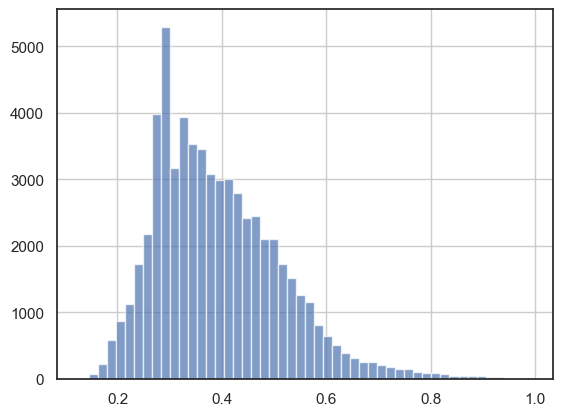

In [522]:
import seaborn as sns
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)
plt.show()

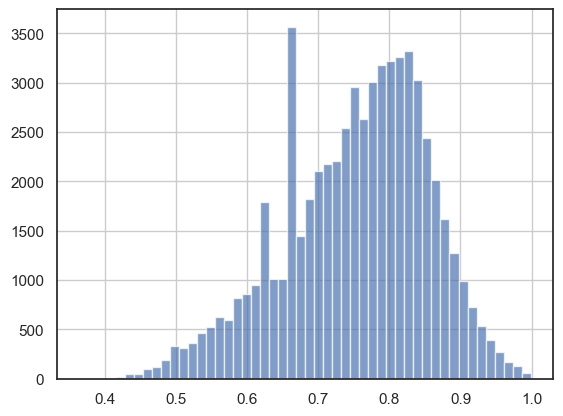

In [523]:
sns.set(style="white")
plt.figure()
sm_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)
plt.show()

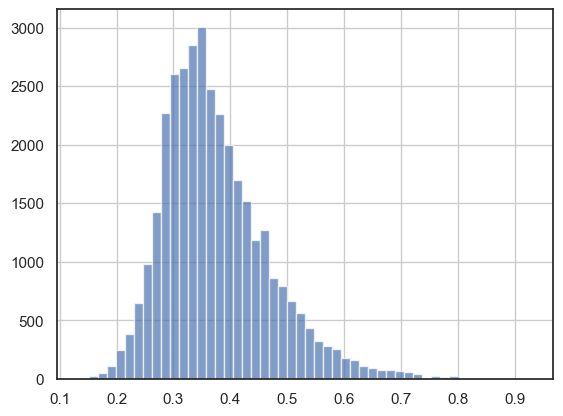

In [524]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_1'].hist(alpha=.7, bins=50)
plt.show()

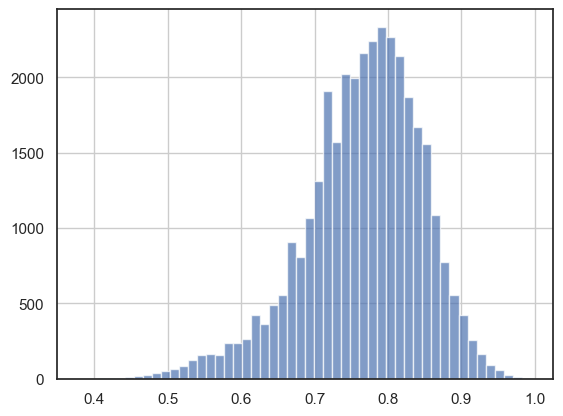

In [525]:
sns.set(style="white")
plt.figure()
sm_all_df.drop_duplicates('revised_text')['max_3'].hist(alpha=.7, bins=50)
plt.show()

In [526]:
compare = score_agg_df.merge(sm_all_df, how = 'left', left_on='origin', right_on='origin')

In [527]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [528]:
compare['max_1_eq'].mean()

0.7065210846396243

In [529]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.6310929458068423

In [530]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [531]:
compare['max_3_eq'].mean()

0.8499367761877044

In [532]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.8113684529215864

In [533]:
len(score_df[(score_df.max_3>0.8) & (score_df.max_1>1./3)])

68410

In [534]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [535]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [536]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,6,0.163718,0.085216,0.280832,0.310720,0.030539,0.108568,0.008998,0.004779,0.003014,...,Criteria iv,0.300038,Criteria i,0.110439,Criteria iii,0.391179,0.801656,True,True,1.0
1,7,0.167033,0.084983,0.267453,0.304577,0.030154,0.122434,0.010389,0.005576,0.003196,...,Criteria iv,0.300537,Criteria i,0.111514,Criteria iii,0.387872,0.799923,True,True,1.0
2,10,0.145369,0.133964,0.213757,0.243041,0.029157,0.108096,0.052678,0.034805,0.018227,...,Criteria iv,0.225481,Criteria ii,0.183531,Criteria i,0.449886,0.858898,True,True,0.5
3,11,0.076119,0.089460,0.266471,0.234519,0.053818,0.085219,0.074331,0.058889,0.032048,...,Criteria iv,0.205980,Criteria iii,0.132468,Criteria ii,0.378402,0.716850,True,False,1.0
4,12,0.057712,0.137347,0.384181,0.192520,0.054644,0.106413,0.035951,0.008720,0.009331,...,Criteria iv,0.247151,Criteria iii,0.187583,Criteria ii,0.351008,0.785742,True,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49818,116670,0.054110,0.117932,0.374972,0.214453,0.053853,0.143065,0.015148,0.010605,0.006706,...,Criteria iii,0.236805,Criteria iv,0.161494,Criteria ii,0.416799,0.815098,True,True,0.5
49819,116671,0.051298,0.201248,0.309790,0.134733,0.018713,0.177148,0.037058,0.037359,0.011223,...,Criteria iii,0.297634,Criteria ii,0.185791,Criteria vi,0.334180,0.817606,True,True,1.0
49820,116672,0.071557,0.186005,0.324673,0.162889,0.018604,0.175369,0.024129,0.018525,0.007105,...,Criteria iii,0.222477,Criteria ii,0.184820,Criteria vi,0.365697,0.772994,True,True,1.0
49821,116673,0.063146,0.063445,0.359193,0.133555,0.022294,0.347638,0.003461,0.002547,0.002171,...,Criteria iii,0.322296,Criteria vi,0.163804,Criteria iv,0.350125,0.836224,True,True,1.0


In [537]:
score_final = sm_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [538]:
score_final

,origin,index,index.1,owner,owner_loc,title,description,comments,taken,views,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,6,6,50770113131,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Patio Palacio Minelli,"El palacio Contarini del Bovolo (también llamado palacio Contarini dal Bovolo Minelli) es un pequeño palacio de Venecia, muy conocido por su escalera de caracol exterior, que tiene un gran número de arcos, y que es conocida como la Scala Contarini del Bovolo (del caracol).\n\nEl palacio data del siglo XV, construido por la familia Contarini y está, al parecer, en no muy buen estado de conservación. La escalera de caracol conduce a una galería, desde donde se ofrece una encantadora vista panorámica sobre algunos de los tejados de la ciudad. El palacio está situado cerca de la calle Campo Ma...",3,2010-03-27 12:47:45,90,...,0.110439,Criteria iii,0.391179,0.801656,True,Criteria iv,Criteria iii,Criteria i,True,1.0
1,7,7,50770228312,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Palacio Minelli,"El palacio Contarini del Bovolo (también llamado palacio Contarini dal Bovolo Minelli) es un pequeño palacio de Venecia, muy conocido por su escalera de caracol exterior, que tiene un gran número de arcos, y que es conocida como la Scala Contarini del Bovolo (del caracol).\n\nEl palacio data del siglo XV, construido por la familia Contarini y está, al parecer, en no muy buen estado de conservación. La escalera de caracol conduce a una galería, desde donde se ofrece una encantadora vista panorámica sobre algunos de los tejados de la ciudad. El palacio está situado cerca de la calle Campo Ma...",7,2010-03-27 12:45:28,238,...,0.111514,Criteria iii,0.387872,0.799923,True,Criteria iv,Criteria iii,Criteria i,True,1.0
2,10,10,50766039303,32980384@N05,"Berlin, Germany",_DSC7807,"Canal Grande on Venetsian pääliikenneväylä. Kuva on otettu Rialton sillalta, joka on yksi Italian tunnetuimmista nähtävyyksistä.",0,2020-08-11 11:48:15,25,...,0.183531,Criteria i,0.449886,0.858898,True,Criteria iv,Criteria iii,Criteria i,True,0.5
3,11,11,50766893587,32980384@N05,"Berlin, Germany",_DSC7805,"Corona-rajoitusten aikaan oli hyvä tilaisuus käydä Venetsiassa, joka normaalisti on täynnä valtameriristeilijöiden tuomia turisteja.",0,2020-08-11 11:44:31,27,...,0.132468,Criteria ii,0.378402,0.716850,True,Criteria iii,Criteria iv,Criteria ii,False,1.0
4,12,12,50766892772,32980384@N05,"Berlin, Germany",_DSC7802,"Corona-rajoitusten aikaan oli hyvä tilaisuus käydä Venetsiassa, joka normaalisti on täynnä valtameriristeilijöiden tuomia turisteja.",0,2020-08-11 11:43:19,20,...,0.187583,Criteria ii,0.351008,0.785742,True,Criteria iii,Criteria iv,Criteria ii,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958,116670,123096,20879329608,23097900@N02,Germany,Hier werden die Pakete mit dem Lastkahn zugestellt.,"<a href=""http://www.brusatotrasporti.it/index.php?pg=Ttrasl"" rel=""noreferrer nofollow"">www.brusatotrasporti.it/index.php?pg=Ttrasl</a>",0,2015-07-03 11:34:58,244,...,0.161494,Criteria ii,0.416799,0.815098,True,Criteria iii,Criteria iv,Criteria vi,True,0.5
80959,116671,123097,21040989736,23097900@N02,Germany,Tür No.342,NaN,0,2015-07-03 11:04:10,156,...,0.185791,Criteria vi,0.334180,0.817606,True,Criteria iii,Criteria ii,Criteria vi,True,1.0
80960,116672,123098,20880415099,23097900@N02,Germany,Ave Maria,NaN,0,2015-07-03 11:34:25,163,...,0.184820,Criteria vi,0.365697,0.772994,True,Criteria iii,Criteria ii,Criteria vi,True,1.0
80961,116673,123099,20879281658,23097900@N02,Germany,Kirchenportal der Chiesa di Santa Sofia.,NaN,0,2015-07-03 12:46:41,237,...,0.163804,Criteria iv,0.350125,0.836224,True,Criteria iii,Criteria vi,Criteria iv,True,1.0


In [539]:
sm_df.to_csv('../../../Venice_Flickr/data_storage/images/sentences_ulmfit.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/data_storage/images/metadata_ulmfit.csv',sep='\t', encoding='utf-8-sig')

In [540]:
sm_df_bert = pd.read_csv('../../../Venice_Flickr/data_storage/images/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final_bert = pd.read_csv('../../../Venice_Flickr/data_storage/images/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

<ipython-input-540-d098a755bcf0>:2: DtypeWarning: Columns (5,824) have mixed types. Specify dtype option on import or set low_memory=False.
  score_final_bert = pd.read_csv('../../../Venice_Flickr/data_storage/images/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')


In [541]:
compare_sent = sm_df.iloc[:,:4]
compare_sent['max_1_col_ulmfit'] = sm_df['max_1_col']
compare_sent['max_2_col_ulmfit'] = sm_df['max_2_col']
compare_sent['max_3_col_ulmfit'] = sm_df['max_3_col']
compare_sent['max_1_ulmfit'] = sm_df['max_1']
compare_sent['max_3_ulmfit'] = sm_df['max_3']
compare_sent['max_1_col_bert'] = sm_df_bert['max_1_col']
compare_sent['max_2_col_bert'] = sm_df_bert['max_2_col']
compare_sent['max_3_col_bert'] = sm_df_bert['max_3_col']
compare_sent['max_1_bert'] = sm_df_bert['max_1']
compare_sent['max_3_bert'] = sm_df_bert['max_3']

In [542]:
compare_sent['same_1'] = compare_sent['max_1_col_ulmfit']==compare_sent['max_1_col_bert']

In [543]:
compare_sent['same_3'] = compare_sent.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [550]:
compare_sent.drop_duplicates()['same_1'].mean()

0.261290812985312

In [549]:
(compare_sent.drop_duplicates()['same_3']>=0.5).mean()

0.5537059126204509

In [546]:
compare_sent[compare_sent['same_3']>=0.5]

,index,sentence,origin,lang,max_1_col_ulmfit,max_2_col_ulmfit,max_3_col_ulmfit,max_1_ulmfit,max_3_ulmfit,max_1_col_bert,max_2_col_bert,max_3_col_bert,max_1_bert,max_3_bert,same_1,same_3
0,0,It has title of Lonely window,20,en,Criteria iii,Criteria vi,Criteria i,0.250929,0.628690,Criteria x,Criteria i,Criteria iii,0.180201,0.498648,False,0.5
1,1,It has title of Reflection and bridge - Venice,24,en,Criteria iii,Criteria vi,Criteria i,0.280426,0.692337,Criteria i,Criteria ii,Criteria vi,0.626143,0.820457,False,0.5
2,2,"It has tags of nopeople, architecture, outdoors, reflection, buildingexterior, traveldestination, night, sunset, city, cityscape, illuminated, italianculture, water, bridge, sky",24,en,Criteria iii,Criteria vi,Criteria iv,0.650610,0.894722,Criteria iv,Criteria v,Criteria vi,0.306494,0.688902,False,0.5
4,4,"It has tags of venice, venezia, italia, panorama, italy, water, channels, boat, old, ancient, middleage, fish, market, sellers, fishermen",28,en,Criteria iii,Criteria iv,Criteria ii,0.606865,0.829000,Criteria iv,Criteria iii,Criteria ii,0.343468,0.875990,False,1.0
5,5,Panorama view from Fondaco dei Tedeschi's rooftop with view on Rialto bridge,29,en,Criteria iii,Criteria i,Criteria vi,0.290368,0.662512,Criteria vi,Criteria i,Criteria iv,0.365714,0.709372,False,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171017,91496,"It has tags of venezia, italy, veneto, metropolitan city, venice, italy, italie, italia, outdoor, geb, architecture, transporti, parcel service, boat, boat, barge, sestierecannaregio, venice",116670,other,Criteria iii,Criteria iv,Criteria ii,0.401659,0.834411,Criteria iv,Criteria ii,Criteria i,0.440942,0.916597,False,0.5
171019,91498,"It has tags of Venezia, Italy, Veneto, Metropolitan City, Venice, Italy, Italia, Italia, Outdoor, Geb, Architecture, Door, No, Venice",116671,other,Criteria ii,Criteria iii,Criteria iv,0.357152,0.866123,Criteria ii,Criteria i,Criteria iv,0.466190,0.893082,True,0.5
171021,91500,"It has tags of Venezia, Italy, Veneto, Metropolitan City, Venice, Italy, Italia, Italia, Outdoor, Geb, Architecture, Avemaria, Window, Window, Venice",116672,other,Criteria iii,Criteria ii,Criteria iv,0.365819,0.867949,Criteria ii,Criteria i,Criteria iv,0.411557,0.881536,False,0.5
171022,91501,It has title of Door in the Jewish district of Venice.,116674,other,Criteria vi,Criteria iii,Criteria iv,0.407372,0.856523,Criteria i,Criteria iv,Criteria iii,0.366306,0.785971,False,0.5


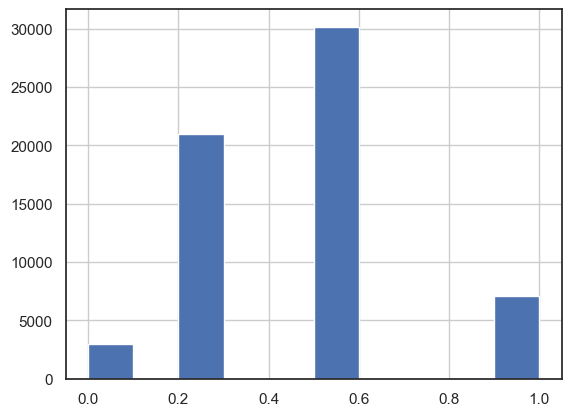

In [548]:
compare_sent.drop_duplicates('sentence')['same_3'].hist()
plt.show()

In [551]:
compare_post = score_final.iloc[:,:2]
compare_post['max_1_col_ulmfit'] = score_final['max_1_col']
compare_post['max_2_col_ulmfit'] = score_final['max_2_col']
compare_post['max_3_col_ulmfit'] = score_final['max_3_col']
compare_post['max_1_ulmfit'] = score_final['max_1']
compare_post['max_3_ulmfit'] = score_final['max_3']
compare_post['max_1_col_bert'] = score_final_bert['max_1_col']
compare_post['max_2_col_bert'] = score_final_bert['max_2_col']
compare_post['max_3_col_bert'] = score_final_bert['max_3_col']
compare_post['max_1_bert'] = score_final_bert['max_1']
compare_post['max_3_bert'] = score_final_bert['max_3']

In [552]:
compare_post['same_1'] = compare_post['max_1_col_ulmfit']==compare_post['max_1_col_bert']

In [553]:
compare_post['same_3'] = compare_post.apply(lambda x: IoU(x[['max_1_col_ulmfit','max_2_col_ulmfit','max_3_col_ulmfit']],
                                                          x[['max_1_col_bert','max_2_col_bert','max_3_col_bert']]),axis=1)

In [554]:
compare_post['same_1'].mean()

0.21665452120104245

In [555]:
compare_post['same_3'].mean()

0.45277966478514886

In [556]:
(compare_post['same_3']>=0.5).mean()

0.5945802403567062

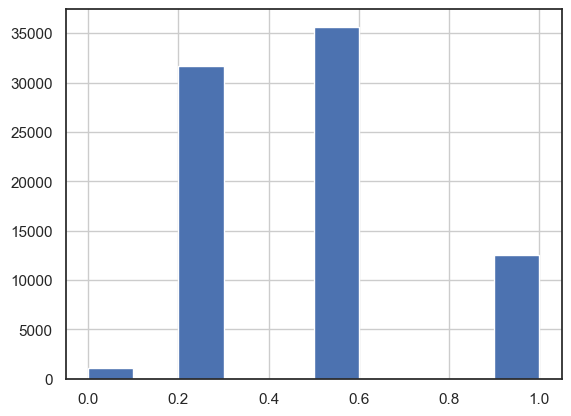

In [557]:
compare_post['same_3'].hist()
plt.show()

In [558]:
compare_sent.to_csv('../../../Venice_Flickr/data_storage/images/sentences_compare.csv',sep='\t', encoding='utf-8-sig')
compare_post.to_csv('../../../Venice_Flickr/data_storage/images/metadata_compare.csv',sep='\t', encoding='utf-8-sig')

## END